----------------------------------------------------
Machine Learning                      

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*

----------------------------------------------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#1. Introduction to ensembles

The goal of ensemble learning is to combine a set of base learners to build an improved prediction model. The key idea  behind ensembles lies in exploiting the diversity among the base learners; the way of generating this diversity let us classify these methods into two main types:

* **Bagging**: the diversity  among classifiers is generated using different partitions of the training data.
* **Boosting**: it sequentially train a set of weak classifiers using modified versions of the data.

We have already seen a kind of these methods: *Random Forests (RF)*. Remember that RF train a set of trees, each tree use a different subset of samples and features, and later combine their outputs. So, we can say that RF is a Bagging method.


**NOTE**: here, we are going to review these methods (and their implementations) for the binary clasification case, but we can find similar approaches for regression and multiclass problems.


Ensemble: model stronger. Combine other simple models. We need that the output of the simple we use are different. We need diversity of output. A Random Forest is an example of an example because it combines trees.

# 2. Bagging: Boostrap Aggregating

A bagging ensemble combines a set of classiffiers where each base learner is trained with a bagged subset of the training samples. This bagging subsampling consists in randomly, and with replacement,  choosing multiple random samples from the original training data.

Once the set of base learners is trained, the final ensemble output is obtained by averaging all learner's outputs. In the classification case, usually a majority vote is applied.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bagging.png" width="48%" >

Bagging models can be trained in sklearn using the class [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) which allows you to define a base learner/estimator along with different parameters adjust the strategy to draw random subsets. Additionaly, sklearn also includes two specific methods for bagged ensembles of decision trees:
* **[Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)** which combines a set of trees by sumbsamplig both data and features.

* **[Extremely Randomized Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)**. This ensemble works as a RF, but instead of looking for the most discriminative thresholds, it forces additional diversity by using random thresholds for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.


(*) Figure from https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de


**References**

L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.


Select in different subset using boostrap (the same data can be in the bag, it's like "with replacement") To combine the output (average or mayority vote if classification).

### Create a bagged ensemble

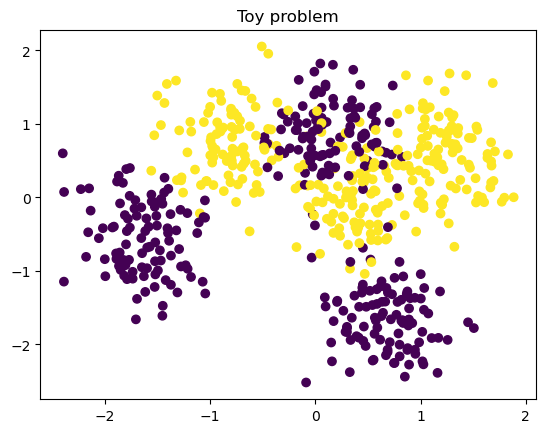

In [2]:
# Generate a toy problem

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
n_samples = 1000
random_state = 170
X, y = make_blobs(n_samples=n_samples, centers=6,cluster_std = 2, random_state=random_state)
# Convert to binary
y[y==2]=0
y[y==3]=0
y[y==4]=1
y[y==5]=1

# Create data partitions
X_train_2D, X_test_2D, Y_train_2D, Y_test_2D = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train_2D = scaler.fit_transform(X_train_2D)
X_test_2D = scaler.transform(X_test_2D)

plt.figure()
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train_2D)
plt.title("Toy problem")
plt.show()

### Step 1: Subsampling
Let's train several decision trees with subsampled versions of the training data.

In [3]:
# Some utility functions

def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points

    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

In [4]:
def plot_boundary_review(clf, X, Y, plt):
    """
    Plot decision boundaries for a single classifier or ensemble of classifiers.
    """
    # Define the plot grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    plot_step = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Handle both single classifiers and ensembles
    if isinstance(clf, list):  # Ensemble of classifiers
        Z = np.zeros((len(clf), xx.ravel().shape[0]))
        for t, sub_clf in enumerate(clf):
            Z[t, :] = sub_clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.mean(axis=0)
    else:  # Single classifier
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape the result for plotting
    Z = Z.reshape(xx.shape)

    # Plot the contour and training data
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolor="k", s=20)


Accuracy tree 0: 0.85
Accuracy tree 1: 0.78
Accuracy tree 2: 0.73
Accuracy tree 3: 0.84
Accuracy tree 4: 0.74
Accuracy tree 5: 0.78
Accuracy tree 6: 0.76
Accuracy tree 7: 0.76
Accuracy tree 8: 0.77
Accuracy tree 9: 0.71


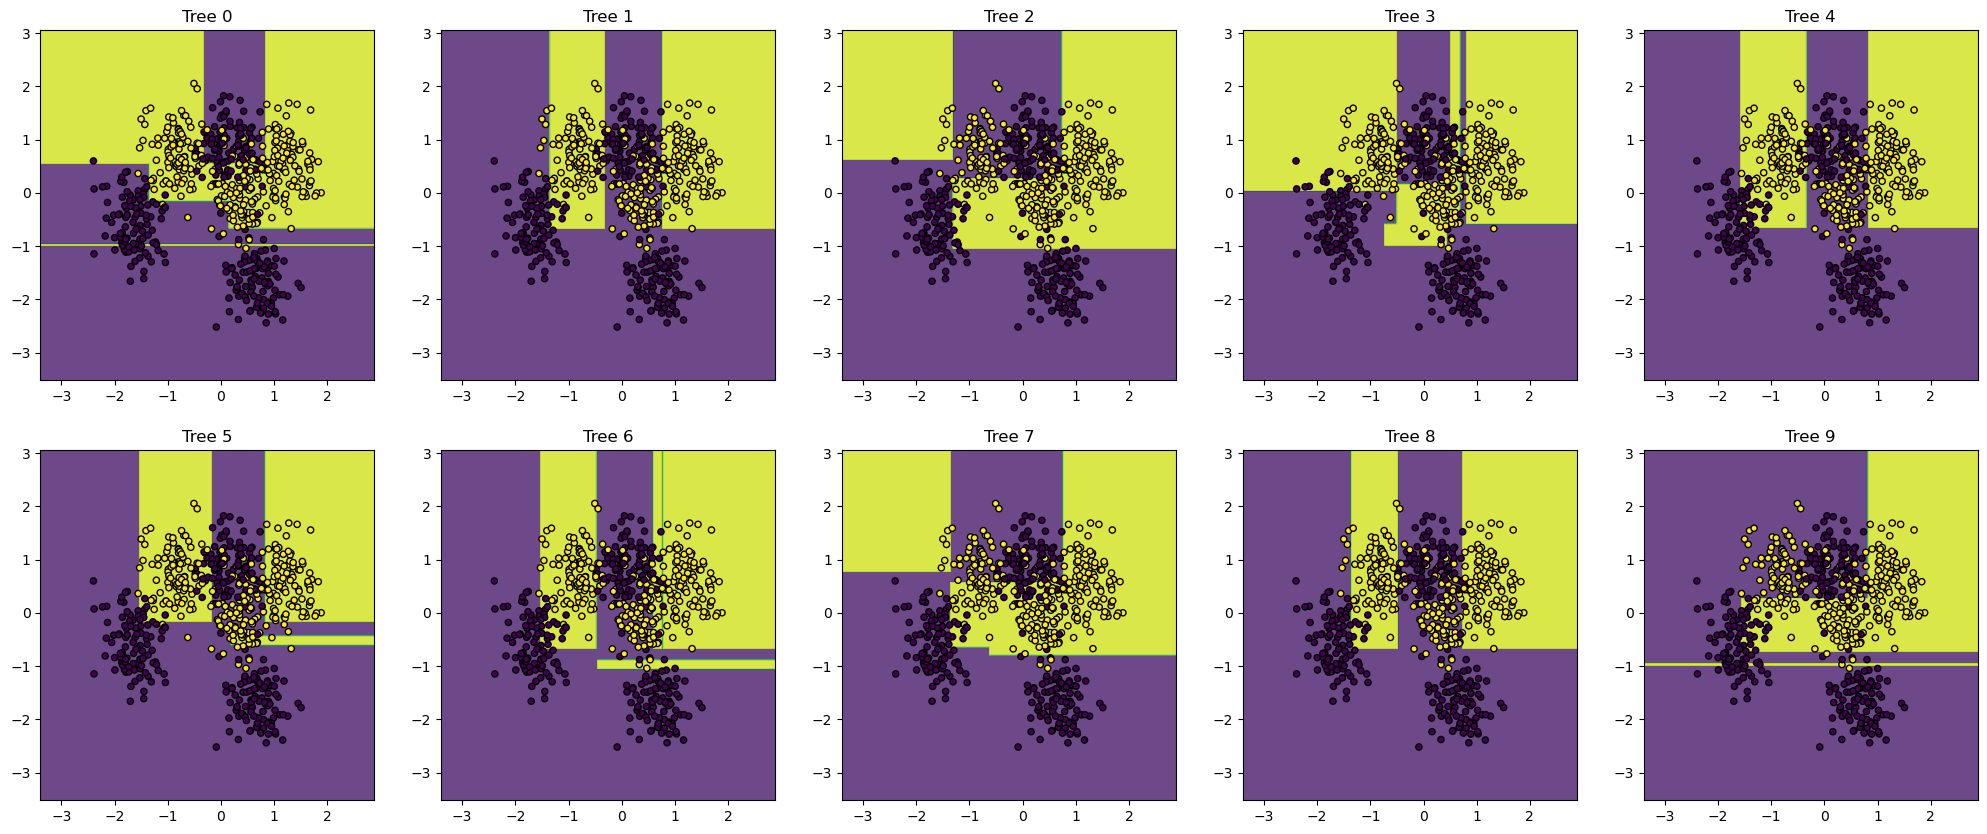

In [5]:
from sklearn import tree
import copy
import numpy as np
import matplotlib.pyplot as plt

# Some parameters
max_depth = 4
T = 10
nperc = 0.4  # subsampling subset
N = X_train_2D.shape[0]
Ntest = X_test_2D.shape[0]
Nsub = int(nperc * N)  # Changed np.int to int

# Define the base classifier
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
ensemble_clf = []
o_train = np.zeros((T, N))
o_test = np.zeros((T, Ntest))

plt.figure(figsize=(25, 10))
np.random.seed(0)

# Repeat this T times
for t in range(T):
    # Subsampling with replacement
    samples_bag = np.random.choice(N, Nsub, replace=True)  # Changed np.int to int
    X_train_sub = X_train_2D[samples_bag, :]
    Y_train_sub = Y_train_2D[samples_bag]

    # Train a bagged tree
    clf_tree.fit(X_train_sub, Y_train_sub)
    ensemble_clf.append(copy.copy(clf_tree))

    # Get and save soft-output
    o_train[t, :] = clf_tree.predict_proba(X_train_2D)[:, 1]  # Probability of class 1
    o_test[t, :] = clf_tree.predict_proba(X_test_2D)[:, 1]  # Probability of class 1

    # Compute test predictions
    acc = clf_tree.score(X_test_2D, Y_test_2D)
    print(f'Accuracy tree {t}: {acc:.2f}')

    # Plot the solution
    plt.subplot(2, 5, t + 1)
    # Inside the loop, modify this line
    plot_boundary_review(clf_tree, X_train_2D, Y_train_2D, plt)
    plt.title('Tree ' + str(t))

plt.show()


### Step 2: Combining the outputs

In classification problems we can find two approaches to obtain the final output of the ensemble:

1. **Calculating the mode of the outputs of the base classifiers**.
When we work with classification problems, it is quite common to obtain the ensemble output as the most frequent output. With this scheme, the output of each base classifier is considered to be a vote and the final ensemble output is calculated as the majority vote.


2. **Calculating the average of the outputs of the base classifiers**.
Another option is to leverage the outputs of the classifiers to compute the final prediction as an average of all the predictions of the base classifiers. This option is also used in classification problems, but this is the typical approach for regression problems.




In [6]:
# Solution computing the ensemble output with the mode
from scipy import stats
from sklearn.metrics import accuracy_score
# Use the values saved in o_train and o_test

# Convert soft-output to target values
o_train_pred = np.where(o_train > 0.5, 1, 0)
o_test_pred = np.where(o_test > 0.5, 1, 0)

# Compute the mode
f_train_pred = np.squeeze(stats.mode(o_train_pred, axis=0)[0]) #we select the mayority data
f_test_pred = np.squeeze(stats.mode(o_test_pred, axis=0)[0])

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test_2D)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.80


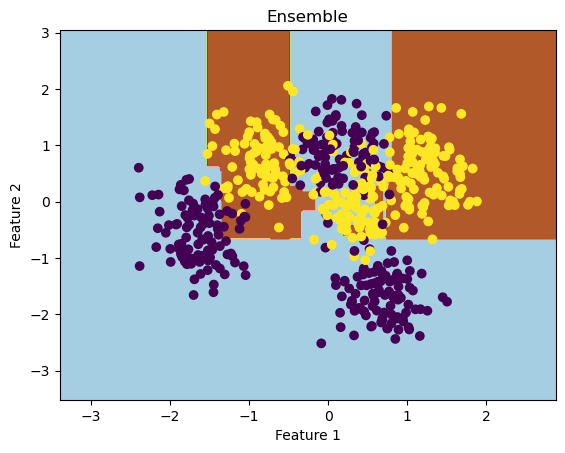

In [7]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z_ens_pred = np.squeeze(stats.mode(Z, axis=0)[0])

    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train_2D, Y_train_2D, plt)
plt.title('Ensemble')
plt.show()

In [8]:
# Solution computing the ensemble output with the mean
# Use the values saved in o_train and o_test

# Compute the mode
f_train_pred = np.where(np.mean(o_train, axis=0) > 0.5, 1, 0)
f_test_pred = np.where(np.mean(o_test, axis=0) > 0.5, 1, 0)

# Final ensemble performance
acc_ens = accuracy_score(f_test_pred, Y_test_2D)
print('Ensemble accuracy: %2.2f'%(acc_ens))

Ensemble accuracy: 0.85


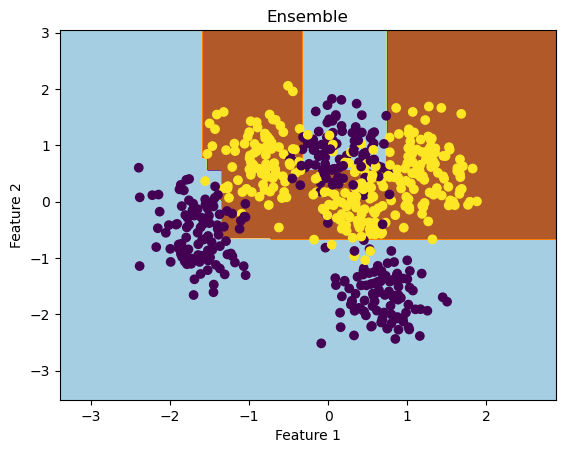

In [9]:
def plot_boundary(ensemble_clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    Z = np.zeros((len(ensemble_clf), xx.ravel().shape[0]))
    for t, clf in enumerate(ensemble_clf):
      Z[t,:] = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    Z_ens_pred = np.where(np.mean(Z, axis=0) > 0.5, 1, 0)
    Z_ens_pred = Z_ens_pred.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z_ens_pred, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    #for i, color in zip(range(n_classes), plot_colors):
    #    idx = np.where(Y == i)
    #    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

plt.figure()
plot_boundary(ensemble_clf, X_train_2D, Y_train_2D, plt)
plt.title('Ensemble')
plt.show()

# 3. Working with Bagging methods

## 3.1. Load and prepare the data

For this lab session, let's work over the  [Pima Diabetes data set](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) a binary classification problem aimed to diabetes disease from a  several medical predictors: the number of pregnancies the patient has had, their BMI, insulin level, age, and so on..

The next cell code loads and preprocesses the data for you by
* Loading the dataset
* Creating training and testing partitions with the 75% and 25% of the original data. The seed is set to $0$ to reproduce the results.
* Normalizing the data to zero mean and unitary standard deviation

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the random generator seed to compare results
np.random.seed(0)

import pandas as pd
data = pd.read_csv('diabetes.csv')
data.head()

X = data.values[:,:-1]
Y = data.values[:,-1]

# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0) #import random_state=0

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Along the notebook, you have to analize the model for different parameter values and ranges. Here, you have the definition of these values. For some of them, we have defined a debugging values (to seep up the implementation of the algorithms), but please use the final values to run a final version of the notebook and analyze the results.

In [11]:
# Parameter for code debugging
T=20
niter = 10

# Final parameters for analysis results
#T=50
#niter = 50

# Common parameters
max_depth = 2
n_perc = 0.25
range_perc =  np.logspace(-2, 0, 20)
range_feat = np.arange(0.1, 1.01, 0.1)

## 3.2. Bagging methods in sklearn


### Exercise 1


#### **a)**
Use the model BaggingClassifier of sklearn to train an ensemble of `t` trees with a subsamplig rate of `n_perc` (`max_samples` = `n_perc`) considering each tree has a maximum depth of `max_depth` and use the default values for the remaining parameters.

Analyze the evolution of the train and test accuracy for t from 1 to T.

Later, run the code several times, why do you get different results?


#### Solution

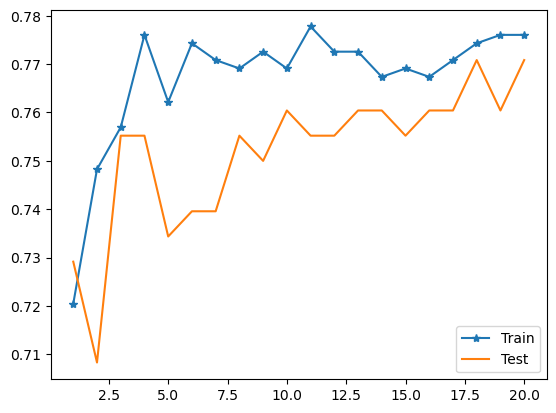

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

a_train=[]
a_test=[]

for t in range(1,T+1):
  clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=n_perc, n_estimators=t, random_state=0)
  clf.fit(X_train, Y_train)

  acc_train = clf.score(X_train, Y_train)
  acc_test = clf.score(X_test, Y_test)

  a_train.append(acc_train)
  a_test.append(acc_test)



plt.plot(range(1,T+1),a_train, label="Train", marker='*')
plt.plot(range(1,T+1),a_test, label="Test")
plt.legend()

plt.show()

#### **b)**

Although the final error tends to be the same, we see that these curves are very noisy and there are many differences between them (mainly at the beginning).

To really analyze the model performance, repeat this experiment for `n_iter` runs, average the results and analyze the results:

* How does the ensemble accuracy behave in mean and standard deviation  as the number of trees increases?. Think about the best way to plot the results to analyze this behavour.


* Would we be able to further improve the (averaged) accuracy by adding more trees? Can we get any additional improvement?

* Do you think there is a risk of overfitting if we add more trees?


#### Solution

In [13]:

from sklearn.ensemble import BaggingClassifier
from sklearn import tree
matrix_train=np.zeros((niter,T))
matrix_test=np.zeros((niter,T))

for i in range(1,niter+1):

  for t in range(1,T+1):
    clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=n_perc, n_estimators=t)
    clf.fit(X_train, Y_train)

    acc_train = clf.score(X_train, Y_train)
    acc_test = clf.score(X_test, Y_test)

    matrix_train[i-1,t-1]= acc_train
    matrix_test[i-1,t-1]= acc_test

mean_train=np.mean(matrix_train, axis=0)
mean_test=np.mean(matrix_test, axis=0)
std_train=np.std(matrix_train, axis=0)
std_test=np.std(matrix_test, axis=0)

plt.figure(figsize=(20, 6))

plt.subplot(2, 2,1)
plt.plot(range(1,T+1),mean_train,label="Train", marker='*')
plt.plot(range(1,T+1),mean_test, label="Test")
plt.legend()
plt.title("Mean score")

plt.subplot(2,2,2)
plt.plot(range(1,T+1),std_train,label="Train", marker='*')
plt.plot(range(1,T+1),std_test, label="Test")
plt.title("Std score")

plt.subplot(2,2,3)
plt.errorbar(range(1,T+1), mean_train, yerr=std_train, fmt='o-', label='Media ± Std train')
plt.title("Media ± Std train")
plt.subplot(2,2,4)
plt.errorbar(range(1,T+1), mean_test, yerr=std_test, fmt='o-', label='Media ± Std test')
plt.title("Media ± Std test")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

errorbar to plot the mean and the variance

We reduce the desviation when we encrease the T value (num of trees,learners).


### Exercise 2.2 Influence of parameter `n_perc` and ensemble diversity

For the above ensemble, analyze the behaviour of the ensemble (with $T$ learners) for different values of `max_samples` (use the range of values defined in `range_perc`) and analyze the performances over the train and test partitions. Compare them with that of a single decision tree (with `max_depth`) also trained with `max_samples` samples. For both approaches, run  `n_iter` iterations and average the results to obtain representative performance curves.


#### **a)** Analyze the results and answer the following questions:
* What is the advantage of the ensemble compared to a stand-alone tree?

* Is this advantage equal for any value of `max_samples`?


#### Solution

In [14]:
range_perc =  np.logspace(-2, 0, 20)
print((X_train.shape[0]*range_perc))
print((X_train.shape[0]*range_perc).astype(int))

[  5.76         7.33982392   9.35295402  11.91823535  15.18710918
  19.35255333  24.66047462  31.42422594  40.04310506  51.02592713
  65.02106256  82.85471357 105.57968894 134.53755662 171.43784304
 218.45895499 278.37678174 354.72856957 452.02174292 576.        ]
[  5   7   9  11  15  19  24  31  40  51  65  82 105 134 171 218 278 354
 452 576]


In [15]:
range_perc =  np.logspace(-2, 0, 20)
clf_train=np.zeros((np.shape(range_perc)[0],niter))
clf_test=np.zeros((np.shape(range_perc)[0],niter))

tree_train=np.zeros((np.shape(range_perc)[0],niter))
tree_test=np.zeros((np.shape(range_perc)[0],niter))



for index, max_samples in enumerate(range_perc):


  for i in range(1,niter+1):

    #ensemble trees
    clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=max_samples, n_estimators=T)
    clf.fit(X_train, Y_train)
    acc_train_clf = clf.score(X_train, Y_train)
    acc_test_clf = clf.score(X_test, Y_test)

    clf_train[index,i-1]=acc_train_clf
    clf_test[index,i-1]=acc_test_clf

    #one tree
    tree_model=BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=max_samples, n_estimators=1)
    tree_model.fit(X_train, Y_train)
    acc_train_tree = tree_model.score(X_train, Y_train)
    acc_test_tree = tree_model.score(X_test, Y_test)
    tree_train[index,i-1]=acc_train_tree
    tree_test[index,i-1]=acc_test_tree

tree_train_mean=np.mean(tree_train, axis=1)
tree_test_mean=np.mean(tree_test, axis=1)
clf_train_mean=np.mean(clf_train, axis=1)
clf_test_mean=np.mean(clf_test, axis=1)


plt.plot(range_perc,clf_train_mean,label="Train ensemble", marker='*',color='b')
plt.plot(range_perc,tree_train_mean, label="Train tree",color='y')
plt.plot(range_perc,clf_test_mean,label="Test ensemble", marker='*',color='b')
plt.plot(range_perc,tree_test_mean, label="Test tree",color='y')
plt.legend()
plt.title("Mean score")

Text(0.5, 1.0, 'Mean score')

with low samples the advantage we get is 20% better with ensamble.

con pocas samples tenemos mas diversity y esto le beneficia al ensamble method.

Lo mejor se encuentra con alta diversidad, por tanto pocas samples (trade-off).

si uitlizamos todas las samples debería ser igual la performance of a single tree and the ensemble should be the same, but is not because of the replacement (no puedes estar seguro de que se esté utilizando todo el training data) the subsampling of the bagging is with replacement.

#### **b)** Now analyze the **diversity** among their base learners' outputs for different `max_samples` rates.

You can analyze this diversity by measuring the correlation among the learners' outputs over either the training  or test data. The following code cell includes a function to compute this diversity.

Finally, analyze the results. Which is better, a high or low diversity?

To answer this question, it can be interesting to jointly analyze the diversity and the ensemble accuracy for different `max_samples` values. And do not forget to average your results for different runs.

In [16]:
def computeDiversity(clf, X):

  '''clf: sklearn bagged ensemble method (such as BaggingClassifier)
     X : observation data matrix'''

  T = len(clf.estimators_) #num of learners
  f_train = np.zeros((T,X.shape[0]))
  for t in range(T):
    f_train[t,:] = clf.estimators_[t].predict_proba(X[:,clf.estimators_features_[t]])[:,1] + 1e-6*np.random.randn(X.shape[0]) #prediction of each learners
#computing the output of the t learner (probability of being in class 1). using al the features (estimators_feater)
  Matrix_corr = np.corrcoef(f_train)  #give the matrix with all the correlation
  corrValues = np.triu(Matrix_corr, k=1) # nos quedamos con la upper part
  corrValues = corrValues[np.nonzero(corrValues)]
  Diversity = 1-np.mean(np.abs((corrValues)))
  return Diversity


#### Solution

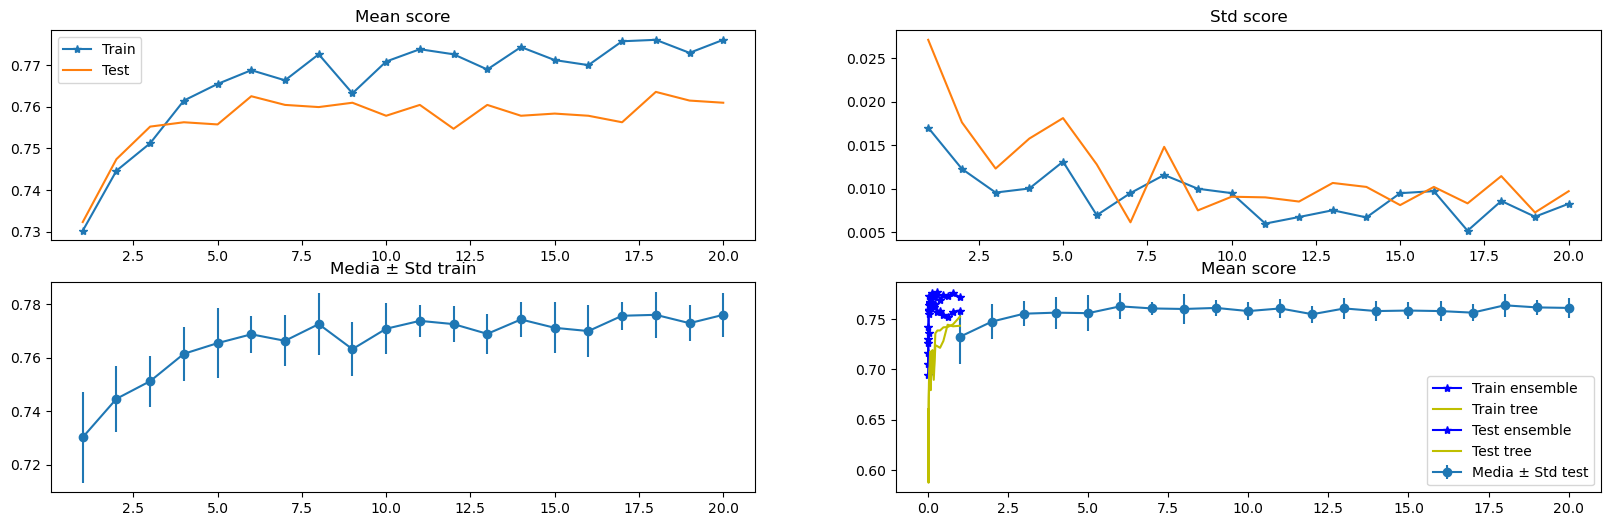

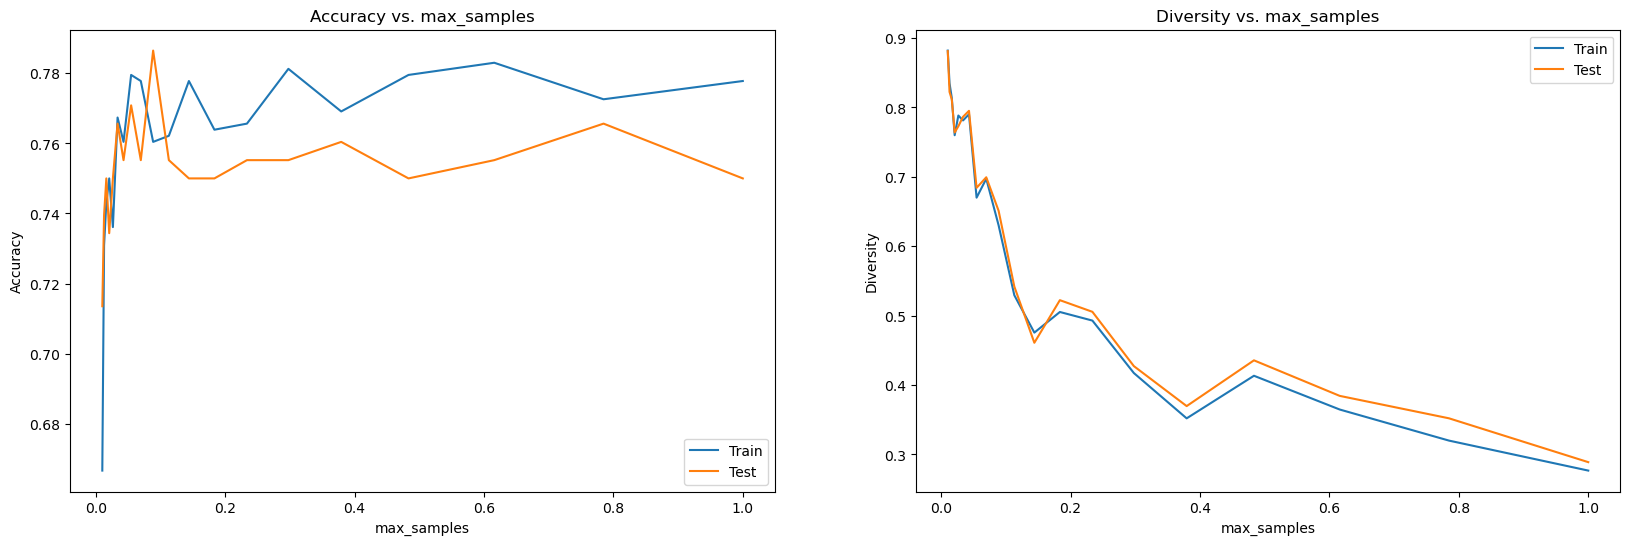

In [17]:
diversity_arr_train=[]
accuracy_train=[]
diversity_arr_test=[]
accuracy_test=[]
# Do it in different iterations
for max_samples in range_perc:

      clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=max_samples, n_estimators=T)
      clf.fit(X_train, Y_train)
      diversity_train=computeDiversity(clf, X_train)
      diversity_test=computeDiversity(clf, X_test)
      diversity_arr_train.append(diversity_train)
      diversity_arr_test.append(diversity_test)
      acc_train_clf = clf.score(X_train, Y_train)
      acc_test_clf = clf.score(X_test, Y_test)
      accuracy_train.append(acc_train_clf)
      accuracy_test.append(acc_test_clf)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range_perc, accuracy_train, label='Train')
plt.plot(range_perc, accuracy_test, label='Test')
plt.title('Accuracy vs. max_samples')
plt.legend()
plt.xlabel('max_samples')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(range_perc, diversity_arr_train, label='Train')
plt.plot(range_perc, diversity_arr_test, label='Test')
plt.title('Diversity vs. max_samples')
plt.legend()
plt.xlabel('max_samples')
plt.ylabel('Diversity')

plt.show()


 Bagging utiliza muestreo bootstrap para generar subconjuntos de datos para cada árbol. Cuando max_samples es pequeño, cada árbol se ajusta a un subconjunto más pequeño de datos, lo que puede llevar a una mayor diversidad porque cada árbol ve una muestra diferente de ejemplos. Sin embargo, a medida que max_samples se acerca a 1, los subconjuntos de datos de entrenamiento se vuelven más similares, lo que puede reducir la diversidad.

Max samples are critical to train our models

So far, we have used 25% of the data to train each base classifier. One might think, that if we use more samples, we would improve the performances of these base classifiers and, therefore, the performances of the final ensemble. However, this does not guarantee improved results.

In Bagging models there is always a trade-off between the performance of the base classifier and the gain obtained in the ensemble. Using more samples to train can bring advantages to the ensemble if the base classifiers are very bad, but if these models already perform quite well, are very stable and their outputs are very similar (no diversity), the improvement brought by the ensemble is reduced....


#### **c)** Optimum selection of `max_samples` parameter

From the above results, it is clear that the selection of the `max_samples` value is critical to obtain good performance in the ensemble. Select this value by cross validation.

#### Solution

In [18]:
from sklearn.model_selection import  cross_val_score
cv_scores=[]

for max_samples in  (range_perc):

    clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(), max_samples=max_samples, n_estimators=T)

    # K-FOLDs=5
    scores = cross_val_score(clf, X_train, Y_train, cv=5)

    mean_score = np.mean(scores)

    cv_scores.append(mean_score)

# Find the max_samples value with the highest cross-validated accuracy
best_max_samples = range_perc[np.argmax(cv_scores)]


print("Best max_samples value:", best_max_samples)

Best max_samples value: 0.18329807108324356


With high value of T we get a low variance of the max_samples

### Exercise 2.3 Can we increase the ensemble diversity with other schemes?


#### **a)** Exploring other diversity strategies

A very simple way to increase diversity is to do data and feature subsampling at the same time (subsampling the training data matrix by rows and by columns). To do this, you can use the `BaggingClassifier` class since it has another parameter `max_features` that allows to control the number or percentage of variables to use.

*Note that in previous experiments this parameter was set to $1.0$ (default value), so a none feature subsamplig has been applied*.

To analyze the influence of this kind of subsampling, now explore both the diversity and the ensemble performance and diversity for different values of `max_samples` and  `max_features` (using `range_feat`). Discuss the obtained results in comparison with those of Exercise 2.2.


#### Solution

In [19]:
print(range_feat)
print(range_perc)
print(range(len(range_perc)))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818
 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499
 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]
range(0, 20)


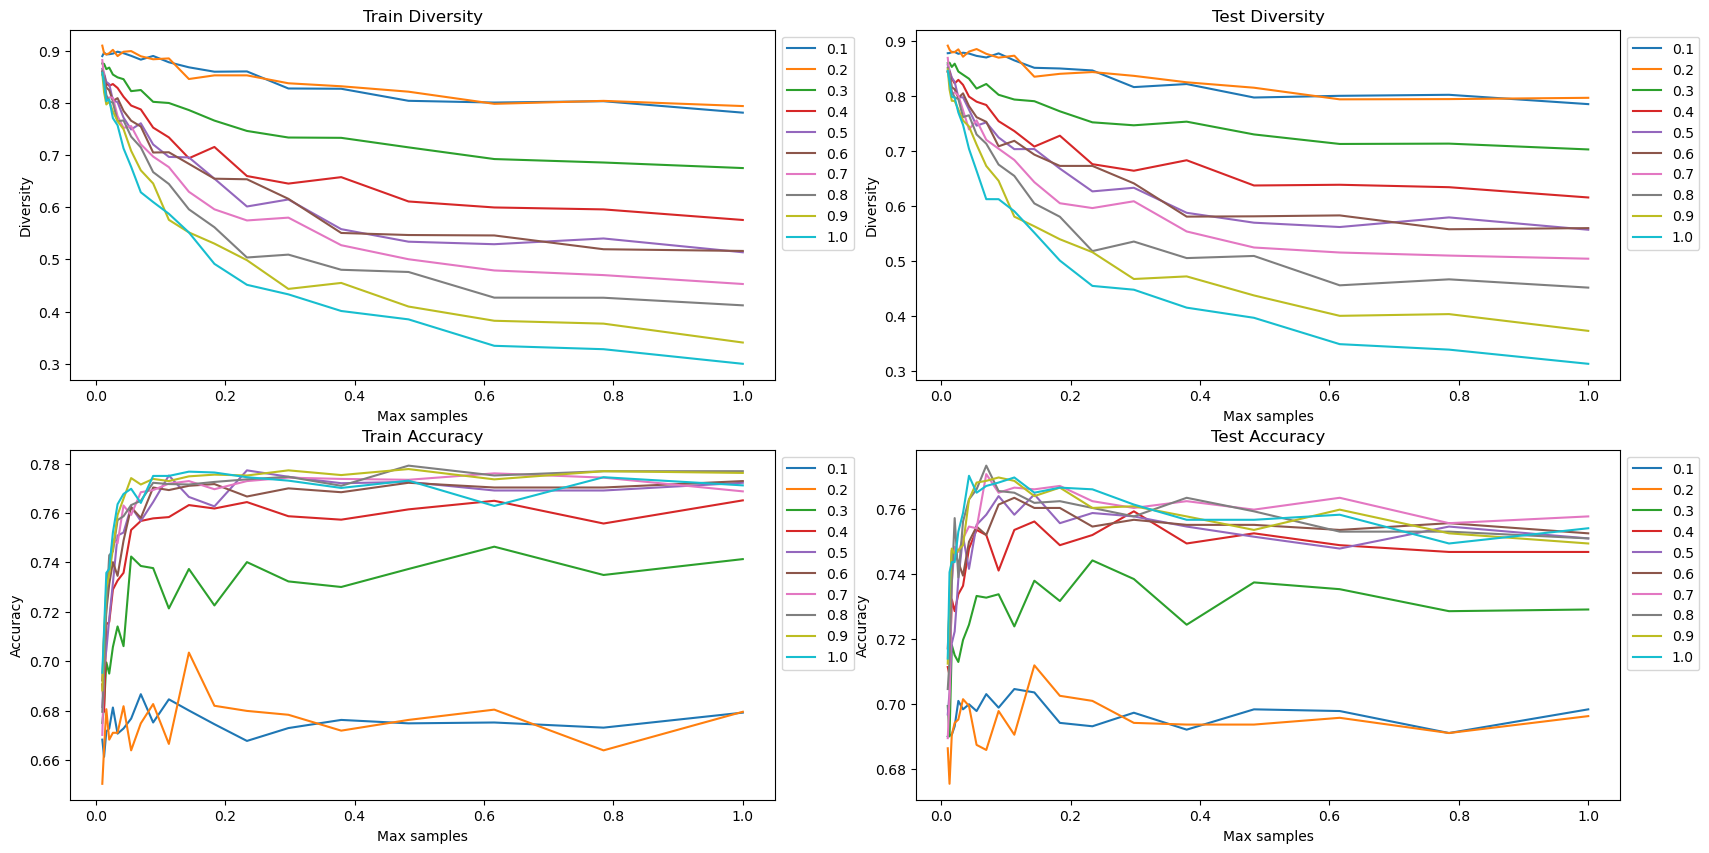

In [20]:
diversity_arr_train=np.zeros((len(range_perc),len(range_feat)))
diversity_arr_test=np.zeros((len(range_perc),len(range_feat)))
accuracy_arr_train=np.zeros((len(range_perc),len(range_feat)))
accuracy_arr_test=np.zeros((len(range_perc),len(range_feat)))
niter=10

for id1, max_sampling in enumerate (range_perc):
  for id2,max_feature in enumerate(range_feat):
      diversity_train_temp=[]
      diversity_test_temp=[]
      accuracy_train_temp=[]
      accuracy_test_temp=[]
      for iter in range(niter):
        clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), max_samples=max_sampling, max_features=max_feature, n_estimators=T)
        clf.fit(X_train, Y_train)
        diversity_train=computeDiversity(clf, X_train)
        diversity_test=computeDiversity(clf, X_test)
        diversity_train_temp.append(diversity_train)
        diversity_test_temp.append(diversity_test)
        accuracy_train_temp.append(clf.score(X_train, Y_train))
        accuracy_test_temp.append(clf.score(X_test, Y_test))

      diversity_arr_train[id1,id2]=np.mean(diversity_train_temp)
      diversity_arr_test[id1,id2]=np.mean(diversity_test_temp)
      accuracy_arr_train[id1,id2]=np.mean(accuracy_train_temp)
      accuracy_arr_test[id1,id2]=np.mean(accuracy_test_temp)

plt.figure(figsize=(20,10))

for i in range(len(range_feat)):
    plt.subplot(2,2,1)
    plt.title("Train Diversity")
    plt.xlabel("Max samples")
    plt.ylabel("Diversity")
    plt.plot(range_perc, diversity_arr_train[:, i], label=f'{range_feat[i]:.1f}')
    plt.subplot(2,2,2)
    plt.title("Test Diversity")
    plt.xlabel("Max samples")
    plt.ylabel("Diversity")
    plt.plot(range_perc, diversity_arr_test[:, i], label=f'{range_feat[i]:.1f}')
    plt.subplot(2,2,3)
    plt.title("Train Accuracy")
    plt.xlabel("Max samples")
    plt.ylabel("Accuracy")
    plt.plot(range_perc, accuracy_arr_train[:, i], label=f'{range_feat[i]:.1f}')
    plt.subplot(2,2,4)
    plt.title("Test Accuracy")
    plt.xlabel("Max samples")
    plt.ylabel("Accuracy")
    plt.plot(range_perc, accuracy_arr_test[:, i], label=f'{range_feat[i]:.1f}')

plt.subplot(2, 2, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2, 2, 2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2, 2, 3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2, 2, 4)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In this case the behavior is not as desired since the feature subsampling does not provide us with advantages in terms of performance, although we do see that it improves diversity. This must be due to the fact that this problem has few input features, so subsampling them makes the individual trees become so bad that we degradate in performance. This is not a generalized effect and normally this type of subsampling usually brings performance advantages, but in this problem there are few input variables and subsampling below 80% clearly deteriorates the performance

#### **b)** Optimum selection of `max_samples` and `max_features` parameter

Now, to complete the desing of the Bagging classfier, select by cross validation the values of  `max_samples` and `max_features` and compare the result with that from Exercise 2.2.c.

#### Solution

In [21]:
from sklearn.model_selection import GridSearchCV

clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), n_estimators=T)
param_grid = {
    'max_samples': range_perc,
    'max_features': range_feat
}

# 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("Best Max Samples:", grid_search.best_params_['max_samples'])
print("Best Max Features:", grid_search.best_params_['max_features'])

Best Max Samples: 0.29763514416313175
Best Max Features: 0.8


We do not improve the result of 2.2.c, we are including an additional parameter which in this particular problem does not provide any advantage and the CV selects a wrong working point...

# 4. Boosting: Real Adaboost

Boosting methods train a sequence of weak classifiers with weighted or emphasized versions of the training data. Each one of these classifiers is weak since its error rate can be only slightly better than random guessing. Finally, to obtain the final ensemble output, the predictions from all of them are then combined through a weighted combination of all learners' outputs.


The most popular boosting algorithm is called **AdaBoost** (Adaptive Boosting). This boosting method trains this sequence of weak classifiers in such way that each new classifier pay more attention to samples missclassified by the previous learners. Versions of this algorithm are:
* AdaBoost.M1 or  “Discrete AdaBoost” where base learners outputs are discrete estimations of the output class. OUTPUT 1 o -1
* “Real AdaBoost”, in this case, the base classifier returns a real-valued prediction (e.g., a probability mapped to the interval [−1,1]).

Let's now go deeper in the working principles of the **Real AdaBoost** algorithm.

--------------
Different Learners focus on different samples using all training data and its features.
Each learner has different weight

## Real Adaboost
Consider we have a binary classification problem given by training dataset $S$ consisting  of $N$ pairs $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^L$ is the $i$-th observation and $y^{(i)}\in\{-1,1\}$  is its associated label.

Real Adaboost (RA) sequentially trains a set of $T$ learners where each learner implements a prediction function $o_t(x) \in [-1,1]$. To learn this prediction function each learner observes the overall training dataset $S$, but an emphasis function $D_t(\mathbf{x})$ is used during its training to make the learner pay more attention to most erroneous samples.
Finally, the ensemble output is obtained as a weighted sum of all learners' outputs:

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

<center>  <img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/boosting.jpg" width="30%" > </center>



* **Emphasis function**:
To force diversity among the base learners, by means of an emphasis function, RA weighs the training observations. Initially all weights are equal:
$$ D_{1}({\bf x}^{(i)}) = \frac{1}{N}   $$

  so that the first learner is trained in the usual manner. For next iterations,  $t = 2,3,\ldots,T$, the emphasis function is updated with the following rule:
$$ D_{t+1}({\bf x}^{(i)}) = \frac{D_{t}({\bf x}^{(i)}) \exp \left( - \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right)}{Z_t}   $$
  where $Z_t$ is a normalization constant making $\sum_{i=1}^N D_{t+1}({\bf x}^{(i)})  = 1$. Note that this update rule increases the emphasis weight for those observations that were misclassified by the previous classifiers, whereas the weights are decreased for those that were  correctly classified. Thus, as new learners are added to the ensemble, most erroneous samples will receive an increased attention.

* **Output weights ($\alpha_t$)**
To obtain the output weights, RA minimizes the exponential loss function:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$
which solution can be analytically computed as
$$\alpha_t = \frac{1}{2} \ln \left( \frac{1+\gamma_t}{1-\gamma_t}\right)$$
where $\gamma_t = \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $. The effect of these weights is to give higher influence to the more accurate classifiers in the ensemble.


**Exponential cost function**

This cost function is quite similar to the one used by logistic regression models and is an upper bound of the classification error.



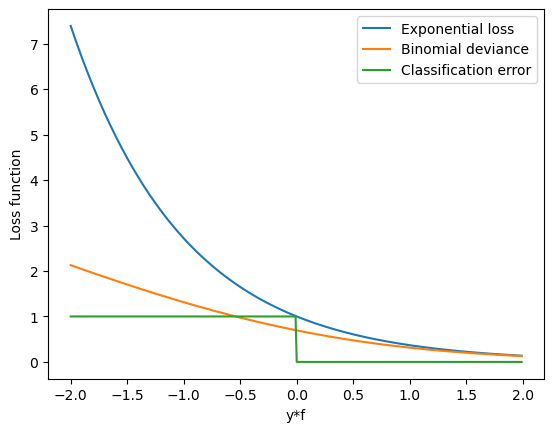

In [22]:
# Plot the exponential loss function (un upper bound of the classfication error)
f = np.arange(-2,2,0.01)
y = 1

l_alpha = np.exp(-y*f)
plt.figure()
plt.plot(y*f,l_alpha, label='Exponential loss')


# Compare with binomial deviance
l_w = np.log(1+ np.exp(f))-y*f
plt.plot(y*f,l_w, label='Binomial deviance')

# Classification error
e_class = np.zeros(f.shape)
e_class[y*f<0] =1
plt.plot(y*f,e_class, label='Classification error')

plt.legend()
plt.xlabel('y*f')
plt.ylabel('Loss function')

plt.show()

## Let's create our Boosting ensemble (Real Adaboost)

### Step 1: Train the first classifier

In [23]:
from sklearn import tree
import copy

N = X_train_2D.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,)) #uniform distribution
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)

# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train_2D, Y_train_2D, sample_weight=Dt) # new parameter: weight to give the importance
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train_2D)[:,1]-1 # we want soft output that is why we use predict_proba. We multiply to 2 because predict proba is a number from 0 to 1 but ada boot need -1,1

# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train_2D-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t


Let's look at the output of this classifier and the most erroneous samples.

In [ ]:
def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

In [ ]:
def plot_boundaryRA(clf_ens, alpha_ens, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = np.zeros((xx.ravel().shape))
    f_t = np.zeros((Y.shape))
    for t, clf in enumerate(clf_ens):
      Z_t = 2*clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]-1
      Z = Z + alpha_ens[t]*Z_t
      o_t = 2*clf.predict_proba(X)[:,1]-1
      f_t = f_t + alpha_ens[t]* o_t
    Z = np.where(Z > 0, 1, 0)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Mark erroneous samples
    # Compute output weights
    error_t =  f_t*(2*Y-1)
    pos_error = np.where(error_t<=0)[0]


    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, label='Training data')
    size=20*np.abs(error_t[pos_error])
    # Plot erroneous data
    plt.scatter(X[pos_error, 0], X[pos_error, 1], c='r', s = size, marker='x', label='Erroneous sample')
    plt.axis("tight")
    plt.legend()

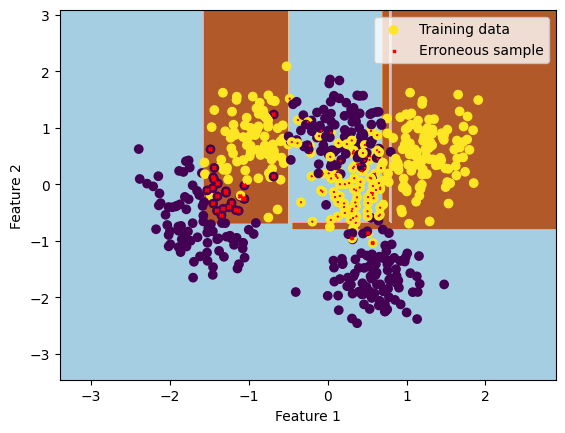

In [ ]:
plt.figure()
plot_boundaryRA(clf_ens, alpha_ens, X_train_2D, Y_train_2D, plt)
plt.show()

yellow with red point: misclasify --> Same approach for purple with red points

### Step 2: Update the emphasis function and add another tree

In [ ]:
# Update emphasis function
Dt = Dt * np.exp(-alpha_t * (o_t*Y_train_2D)) #updated using the emphasis funtion above
Dt = Dt /np.sum(Dt)
# Train a boosted tree (use sample_weight parameter)
clf_tree.fit(X_train_2D, Y_train_2D, sample_weight=Dt)
clf_ens.append(copy.copy(clf_tree))
# Compute tree soft-outputs (interval [-1,1])
o_t = 2*clf_tree.predict_proba(X_train_2D)[:,1]-1

# Compute output weights
gamma_t = Dt @ (o_t*(2*Y_train_2D-1))
alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
alpha_ens.append(alpha_t)
# Update ensemble  output
f_pred_train = f_pred_train + alpha_t * o_t

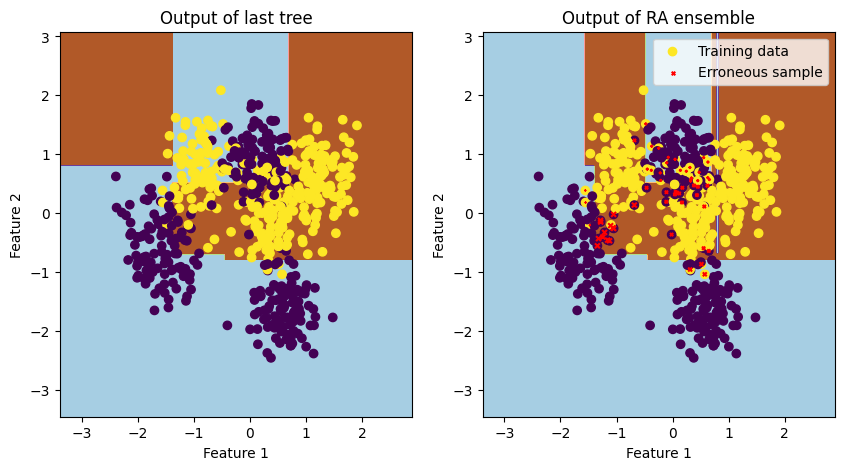

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_boundary(clf_ens[-1], X_train_2D, Y_train_2D, plt)
plt.title('Output of last tree')

plt.subplot(1,2,2)
plot_boundaryRA(clf_ens, alpha_ens, X_train_2D, Y_train_2D, plt)
plt.title('Output of RA ensemble')
plt.show()


### Step T: We repeat this process T times...

<Figure size 2000x2500 with 0 Axes>

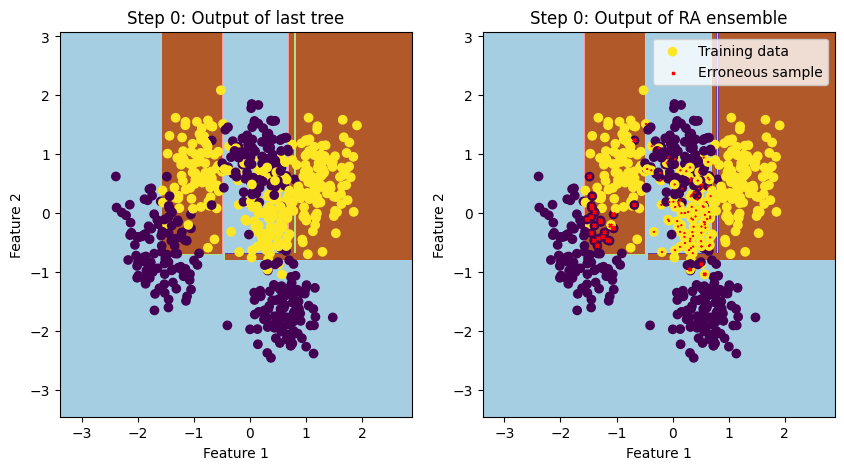

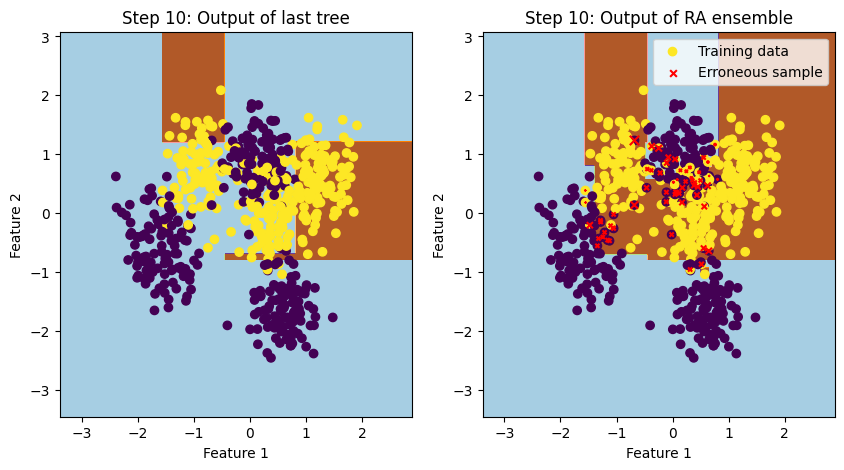

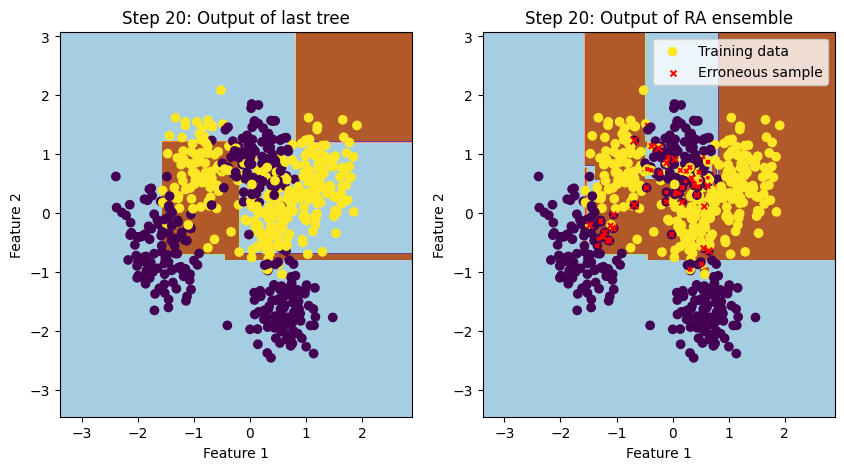

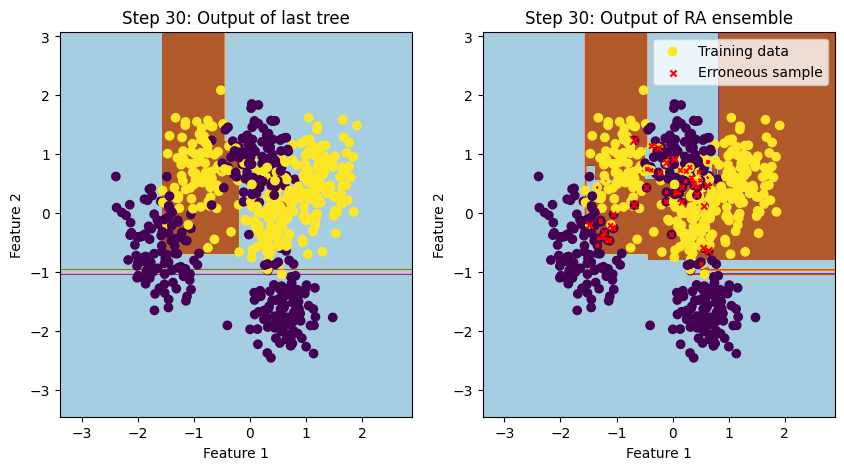

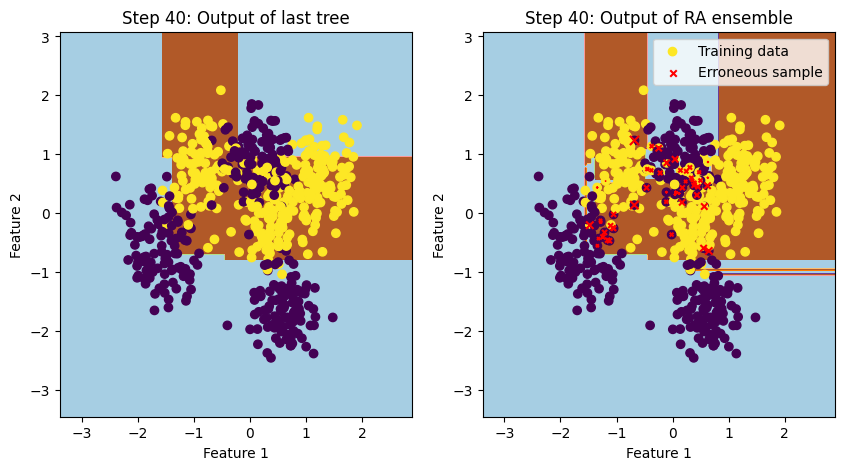

In [ ]:
from sklearn import tree
N = X_train_2D.shape[0]
max_depth =4
clf_ens =[]
alpha_ens = []
f_pred_train = np.zeros((N,))
# Initialize emphasis function
Dt = (1./N) * np.ones((N,))
clf_tree = tree.DecisionTreeClassifier(max_depth=max_depth)

T = 50
plt.figure(figsize=(20,25))
for t in range(T):
  # Train a boosted tree (use sample_weight parameter)
  clf_tree.fit(X_train_2D, Y_train_2D, sample_weight=Dt)
  clf_ens.append(copy.copy(clf_tree))
  # Compute tree soft-outputs (interval [-1,1])
  o_t = 2*clf_tree.predict_proba(X_train_2D)[:,1]-1

  # Compute output weights
  gamma_t = Dt @ (o_t*(2*Y_train_2D-1))
  alpha_t = 0.5* np.log ((1+gamma_t)/(1-gamma_t))
  alpha_ens.append(alpha_t)
  # Update ensemble  output
  f_pred_train = f_pred_train + alpha_t * o_t
  # Update emphasis function
  Dt = Dt * np.exp(-alpha_t * (o_t*Y_train_2D))
  Dt = Dt /np.sum(Dt)
  if (t % 10)==0:
    # Plot the solution
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_boundary(clf_ens[-1], X_train_2D, Y_train_2D, plt)
    plt.title('Step '+str(t)+': Output of last tree')
    plt.subplot(1,2,2)
    plot_boundaryRA(clf_ens, alpha_ens, X_train_2D, Y_train_2D, plt)
    plt.title ('Step '+str(t)+': Output of RA ensemble')
    plt.show()


## Boosting as a gradient descent algorithm

The Real AdaBoost algorithm can be reformulated as a feature construction (*feature engineering*) algorithm in which each classifier provides a new feature to the ensemble and these are combined with some weights $\alpha_t$ to minimize the exponential cost function that minimizes RA.

Thus we can consider that RA trains a sequence of classifiers to build some features $o_t(\mathbf x)$, $t=1, \ldots, T$, so that the final output of the classifier or ensemble are given by a linear combination of the same ones

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

and the weights of this combination are calculated so that the following cost function is minimized:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$

In addition, for the design of these features, at each iteration of the set, RA adds a new variable $o_t(\mathbf x)$ so as to achieve the largest possible reduction of the cost function up to step $t$, i.e.,

$$ \underset{{o_t(\mathbf x)}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t'=1}^t \alpha_{t'} o_{t'}({\bf x}^{(i)}) {y}^{(i)} \right) = \underset{{o_t(\mathbf x)}}{\operatorname{max}} \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $$

That is, finding at each step the $o_t(\mathbf x)$ that provides the largest cost reduction is equivalent to maximizing an emphasized version of the classifier accuracy!!!!

Since adding at each step a new classifier or *feature* that minimizes the cost function is equivalent to moving in the direction of its gradient, this reformulation or reinterpretation of RA falls into the **Gradient Boosting** family of models. The advantage of this view of the problem is that we can choose different cost functions to obtain different Boosting models. In fact, the regression versions are formulated considering this formulation of the problem for the mean square error.





## Boosting implementations

We can find an implementation of the Real AdaBoost classifier in the sklearn library. This class, called [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier), allows us to use  Discrete and Real Adaboost versions by adjusting the parameter `algorithm` to `SAMME` (discrete version) or `SAMME.R` (continuous version), respectivelly.

Additionaly, sklearn also includes an implementation of this family of models when the base classifiers are trees and are inside the [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) model. This class allows us to choose between two cost functions for the ensemble design: (1) the exponential function of the standard AR and (2) the binomial function used by logistic regression models. Besides, this implementation provides two advatanges:
* The base base learner has to be a decision tree, but these trees are designed with an specific criteria to provide improved performance in the combination (mean squeare error or modified versions).
* The combination weigths has to be learnt for any cost function, so they are computed with any gradient descent algorithm.


For the implementation of Gradient Boosting methods it is quite common to use the [XGBoost library](https://xgboost.readthedocs.io/en/latest/index.html), since it provides an efficient implementation with parallelization capabilities (in case we need to work with large datasets). Besides, it has a [sklearn interface](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) which easily allows us integrate it with our common code.


**References**

* Schapire, R.E. "The strength of weak learnability". Machine Learning, 5(2): 1651-1686, 1990.

* Freund, Y. and Schapire, R.E. "Experiments with a new boosting algorithm". Proc. of the 13th International Conference on Machine Learning. pp. 148-156, 1996.

* Friedmann, J. H.,  “Stochastic Gradient Boosting”, 2007.


# 5. Working with Boosting methods

In [ ]:
# Parameter for code debugging
T=20  # here, let's use more trees
niter = 10

# Final parameters for analysis results
T=100
niter = 50

# Common parameters
max_depth = 2

### Exercise 3.1  

#### **a)** Real AdaBoost in sklearn

Uses the `AdaBoostClassifier` model to train a set of `T` decision trees with `max_depth` and analyze their train and test accuracy vs. the number of trees (from 1 to `T`). Use the the implementation of Real Adaboost (`algorithm` = `SAMME.R`).

Discuss the results and answer the following questions:
* Can I add as many trees as I want without incurring in overfitting problems?
* Can I stop adding learners when the train accuracy is $100\%$?

Compare this results and discussion with that of the Bagging ensemble of Exercise 2.1.

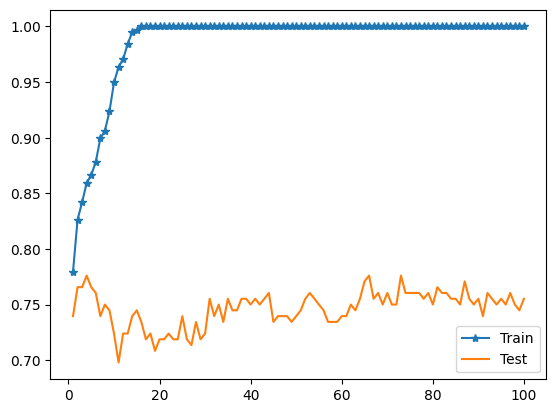

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
a_train=[]
a_test=[]

for t in range(1,T+1):
  clf = AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(max_depth=4),n_estimators=t, algorithm='SAMME.R') # mismo resultado todo el rato

  clf.fit(X_train, Y_train)
  acc_train = clf.score(X_train, Y_train)
  acc_test = clf.score(X_test, Y_test)

  a_train.append(acc_train)
  a_test.append(acc_test)

plt.plot(range(1,T+1),a_train, label="Train", marker='*')
plt.plot(range(1,T+1),a_test, label="Test")
plt.legend()

plt.show()

boostig is reducing the bias. Bagging have high variance that is why we use niter.
the selection of learner going to be critical

#### **b)** Gradient Boosting

Use the `GradientBoostingClassifier` model to train a set of T decision trees with `max_depth`  by Gradient Boosting with an exponential  cost function (`loss= 'exponential'`). Obtain the accuracy evolution with the number of learners. Besides, compare the result with the one obtained by the `AdaBoostClassifier` with `algorithm` = `SAMME.R`.



#### Solution

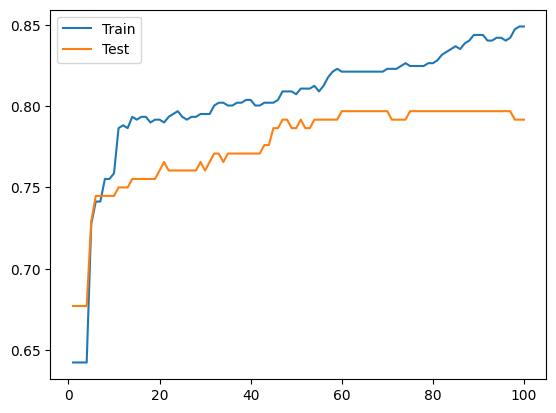

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

a_train=[]
a_test=[]

for t in range(1,T+1):
  clf = GradientBoostingClassifier(loss='exponential',n_estimators=t,max_depth=max_depth)
  clf.fit(X_train, Y_train)
  acc_train = clf.score(X_train, Y_train)
  acc_test = clf.score(X_test, Y_test)

  a_train.append(acc_train)
  a_test.append(acc_test)

plt.plot(range(1,T+1),a_train, label="Train")
plt.plot(range(1,T+1),a_test, label="Test")
plt.legend()

plt.show()

#### **c)** Parameter selection

In these models the selection of the number of learners can be critical, compute the performance of both Real Ababoost and GradientBoosting when T is selected by CV.

#### Solution

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(max_depth=4),algorithm='SAMME.R')
param_grid = {
    'n_estimators': range(1,T+1)
}

# 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("Best n_estimators:", grid_search.best_params_['n_estimators'])

Best n_estimators: 1


In [ ]:
clf = GradientBoostingClassifier(loss='exponential',n_estimators=t,max_depth=max_depth)
param_grid = {
    'n_estimators': range(1,T+1)
}

# 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

print("Best n_estimators:", grid_search.best_params_['n_estimators'])

Best n_estimators: 30


### Exercise 3.2

Finally compare the performance of GradientBoost based models when using the
[XGBoost library](https://xgboost.readthedocs.io/en/latest/index.html), as it provides an efficient implementation with parallelization capabilities (in case we need to work with large datasets). In addition, it has a [sklearn interface](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) that allows us to easily integrate it with our code.

Like the sklearn implementation it is designed to work with decision trees, but it brings us some additional utilities:
* It allows us to do *early_stopping*: if we provide a validation set, it evaluates the performance of the set on it to decide when to stop adding new trees (avoiding overfitting effects).
* It allows to evaluate the set with a subset of the trained trees.

Check the library help to use these utilities to efficiently analyze the performance of the ensemble as a function of the number of trees and, later, to apply an early stopping criterion to select the optimal number of trees in the ensemble. In the latter case, you can use a $40\%$ of the training data for the validation subset and $10$ rounds for the early stopping criteria.

Finally, discuss about the different strategies for crossvalidating $T$ (cross-validation vs early stopping).

#### Solution

In [ ]:
!pip install xgboost

[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[1]	validation_0-logloss:0.53868	validation_1-logloss:0.55526
[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[1]	validation_0-logloss:0.53868	validation_1-logloss:0.55526
[2]	validation_0-logloss:0.49180	validation_1-logloss:0.52332
[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[1]	validation_0-logloss:0.53868	validation_1-logloss:0.55526
[2]	validation_0-logloss:0.49180	validation_1-logloss:0.52332
[3]	validation_0-logloss:0.46293	validation_1-logloss:0.49936
[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[1]	validation_0-logloss:0.53868	validation_1-logloss:0.55526
[2]	validation_0-logloss:0.49180	validation_1-logloss:0.52332
[3]	validation_0-logloss:0.46293	validation_1-logloss:0.49936
[4]	validation_0-logloss:0.44161	validation_1-logloss:0.47588
[0]	validation_0-logloss:0.59627	validation_1-logloss:0.59899
[1]	vali

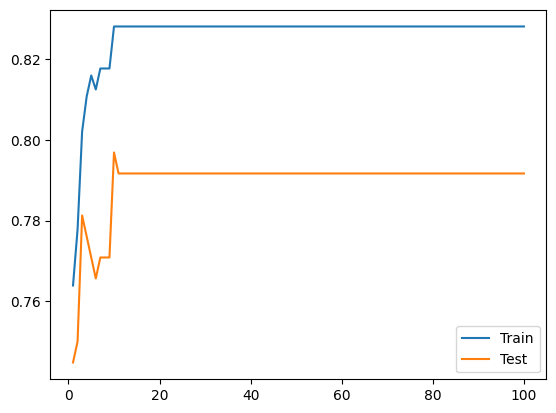

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

a_train=[]
a_test=[]
for t in range(1,T+1):
  early_stop = xgb.callback.EarlyStopping(
  rounds=10, save_best=True)
  clf=XGBClassifier(n_estimators=t, max_depth=4,callbacks=[early_stop],subsample=0.4) # with this type we can create the model and fit it outside of the loop

  clf.fit(X_train, Y_train,eval_set=[(X_train, Y_train),(X_test, Y_test)])
  acc_train = clf.score(X_train, Y_train)
  acc_test = clf.score(X_test, Y_test)

  a_train.append(acc_train)
  a_test.append(acc_test)

plt.plot(range(1,T+1),a_train, label="Train")
plt.plot(range(1,T+1),a_test, label="Test")
plt.legend()

plt.show()

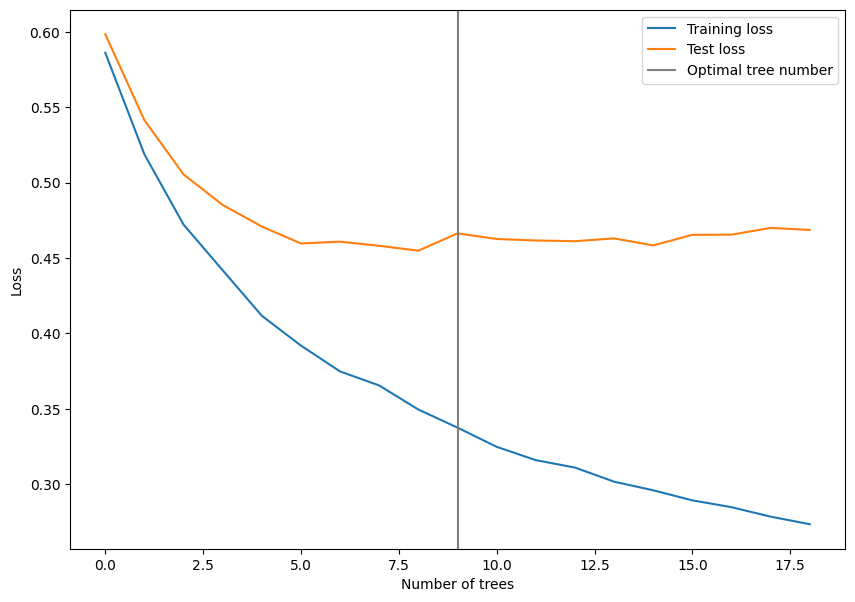

In [ ]:
results = clf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Test loss")
plt.axvline(clf.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

# 6. *Stacking* of classifiers

Stacking is another approach for the ensemble design, in which an ensemble is obtained directly from the combination of the predictions of several different classifiers such as a K-NN, LR, Trees, ..... The idea is that if these models provide different outputs (diversity) simply because they are different models, by combining their outputs we can reduce the final error variance.

There are schemes that use this idea by making different grouping layers where the classifiers are grouped at different levels. The simplest, and usual, scheme with a single aggregation layer is shown in the following figure(*):



<img align="center" src="https://miro.medium.com/max/1400/1*5O5_Men2op_sZsK6TTjD9g.png" width=50%>

To train this model we can use the class [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) of sklearn. The next example defines a *stacking*  ensemble using as base learners K-NN classfiers with different K values and a `Logistic Regression` classfier in the output layer.


(*) Figure from https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define ensemble model
estimators = [('KNN3', KNeighborsClassifier(n_neighbors=3)), ('KNN5',KNeighborsClassifier(n_neighbors=5)), ('KNN10',KNeighborsClassifier(n_neighbors=10)),('KNN20',KNeighborsClassifier(n_neighbors=20))]
ensemble = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Train and test the model
ensemble.fit(X_train_2D, Y_train_2D)
Y_pred = ensemble.predict(X_test_2D)
acc_ens = accuracy_score(Y_test_2D,Y_pred)

print('Stacked ensemble accuracy: %2.2f'%(acc_ens))

Stacked ensemble accuracy: 0.89


In [ ]:
def plot_boundary(clf, X, Y, plt):
    """Plot the classification regions for a given classifier.

    Args:
        clf: scikit-learn classifier object.
        X (numpy dnarray): training or test data to be plotted (number data x number dimensions). Only first two dimensions are plotted
        Y (numpy dnarray): labels of the training or test data to be plotted (number data x 1).
        plt: graphic object where you wish to plot

    """

    plot_colors = "brymc"
    plot_step = 0.02
    n_classes = np.unique(Y).shape[0]
    # Plot the decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.axis("tight")

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y)

    plt.axis("tight")

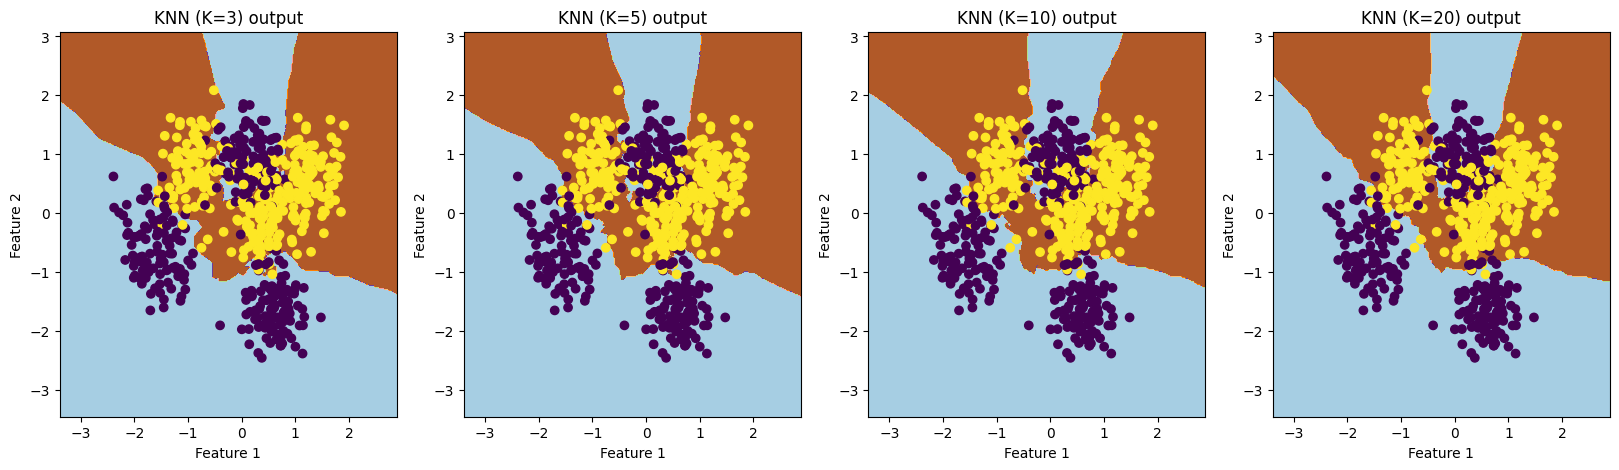

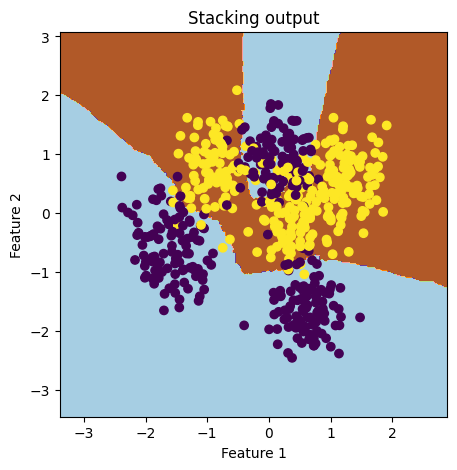

In [ ]:
# Plot the solution
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_boundary(KNeighborsClassifier(n_neighbors=3).fit(X_train_2D, Y_train_2D), X_train_2D, Y_train_2D, plt)
plt.title('KNN (K=3) output')
plt.subplot(1,4,2)
plot_boundary(KNeighborsClassifier(n_neighbors=5).fit(X_train_2D, Y_train_2D), X_train_2D, Y_train_2D, plt)
plt.title('KNN (K=5) output')
plt.subplot(1,4,3)
plot_boundary(KNeighborsClassifier(n_neighbors=10).fit(X_train_2D, Y_train_2D), X_train_2D, Y_train_2D, plt)
plt.title('KNN (K=10) output')
plt.subplot(1,4,4)
plot_boundary(KNeighborsClassifier(n_neighbors=20).fit(X_train_2D, Y_train_2D), X_train_2D, Y_train_2D, plt)
plt.title('KNN (K=20) output')

plt.figure(figsize=(5,5))
plot_boundary(ensemble, X_train_2D, Y_train_2D, plt)
plt.title('Stacking output')
plt.show()



# 7. Imbalanced problems

Class 0: 90.909%, Class 1: 9.091%


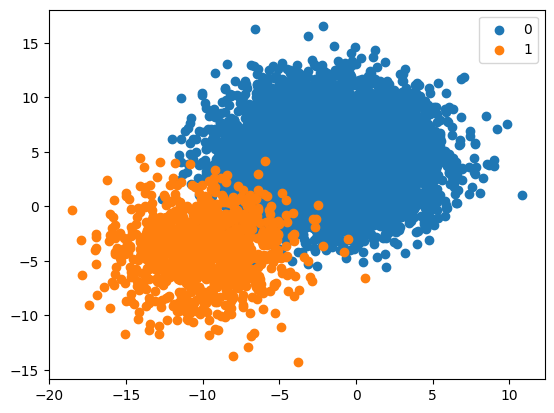

In [ ]:
from sklearn.datasets import make_blobs

# create a dataset with a given class distribution
def get_dataset(proportions):
	# determine the number of classes
	n_classes = len(proportions)
	# determine the number of examples to generate for each class
	largest = max([v for k,v in proportions.items()])
	n_samples = largest * n_classes
	# create dataset
	X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=2, random_state=1, cluster_std=3)
	# collect the examples
	X_list, y_list = list(), list()
	for k,v in proportions.items():
		row_ix = np.where(y == k)[0]
		selected = row_ix[:v]
		X_list.append(X[selected, :])
		y_list.append(y[selected])
	return np.vstack(X_list), np.hstack(y_list)

# scatter plot of dataset, different color for each class
def plot_dataset(X, y):
	# create scatter plot for samples from each class
	n_classes = len(np.unique(y))
	for class_value in range(n_classes):
		# get row indexes for samples with this class
		row_ix = np.where(y == class_value)[0]
		# create scatter of these samples
		plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(class_value))
	# show a legend
	plt.legend()
	# show the plot
	plt.show()

# define the class distribution 1:100
proportions = {0:10000, 1:1000}
# generate dataset
X, y = get_dataset(proportions)
# summarize class distribution:
major = (len(np.where(y == 0)[0]) / len(X)) * 100
minor = (len(np.where(y == 1)[0]) / len(X)) * 100
print('Class 0: %.3f%%, Class 1: %.3f%%' % (major, minor))
# plot dataset
plot_dataset(X, y)

In [ ]:
# Create data partitions
X_train_IB, X_test_IB, Y_train_IB, Y_test_IB = train_test_split(X, y, test_size=.4)

# Normalize the data
scaler = StandardScaler()
X_train_IB = scaler.fit_transform(X_train_IB)
X_test_IB = scaler.transform(X_test_IB)

Let's start analyzing the performance of a KNN classifier for a large value of K...

In [ ]:
from sklearn import neighbors

clf_KNN = neighbors.KNeighborsClassifier(n_neighbors = X_train_IB.shape[0])
clf_KNN.fit(X_train_IB, Y_train_IB)
acc_test_KNN=clf_KNN.score(X_test_IB,Y_test_IB)
print("The test accuracy is %2.2f" %(100*acc_test_KNN))

The test accuracy is 90.61


*What do you think? Is this accuracy good enough?*

The model is mainly trained with class 0 so is not going to distinguish correctly the classes that are 1.

Check the classifier output

In [ ]:
y_pred = clf_KNN.predict(X_test_IB)
print(y_pred)
print('Data classfied as "0":')
print(len(np.where(y_pred==0)[0]))
print('Data classfied as "1":')
print(len(np.where(y_pred==1)[0]))

[0 0 0 ... 0 0 0]
Data classfied as "0":
4400
Data classfied as "1":
0


The KNN classifier always classifies a sample as "0" (the majority class), we haven't learnt anything!  

We can get this same result with a naive classifier model that always predicts the majority class.

We can achieve this using the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) from scikit-learn and use the ‘most_frequent‘ strategy that will always predict the class label that is most observed in the training dataset.

In [ ]:
from sklearn.dummy import DummyClassifier
# define model
clf_Dummy = DummyClassifier(strategy='most_frequent')

clf_Dummy.fit(X_train_IB, Y_train_IB)
acc_test_Dummy=clf_Dummy.score(X_test_IB,Y_test_IB)

print("The test accuracy is %2.2f" %(100*acc_test_Dummy))

The test accuracy is 90.61


So, it seems that acuracy is not a good measure to tell me if a classifier is good or not? In unbalanced problems we have to take into account the percentage of samples in each class (compare with the Dummy) to know if the accuracy is really good or not.


Another option is to use other metrics such as the ROC curve or the AUC.

AUC: 0.5


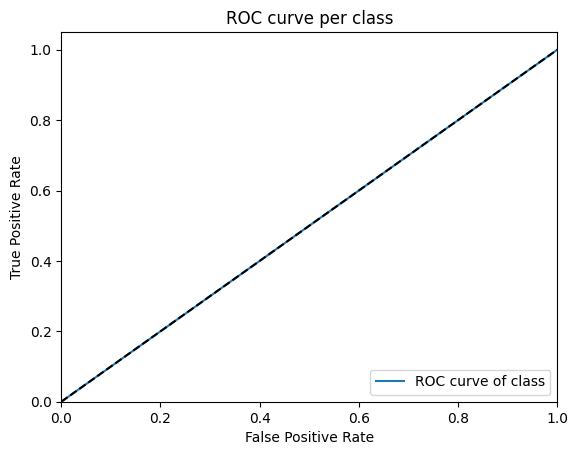

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
o_test = clf_Dummy.predict_proba(X_test_IB)[:,1]
fpr, tpr, _ = roc_curve(Y_test_IB,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

plt.plot(fpr, tpr, label='ROC curve of class')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per class')
plt.legend(loc="lower right")
plt.show()

indica que es el peor de los clasificaores

The test accuracy is 98.48
AUC: 0.9914795725332514


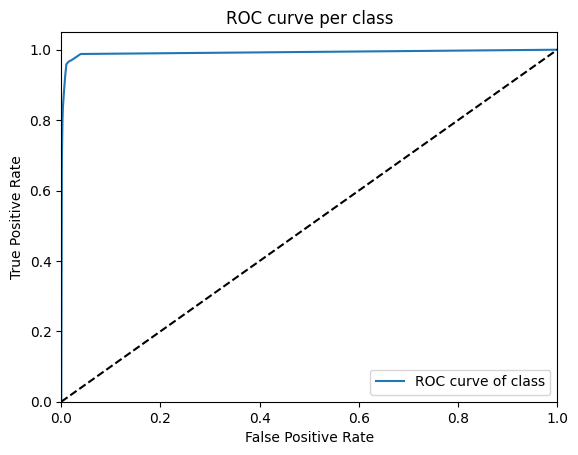

In [ ]:
clf_KNN = neighbors.KNeighborsClassifier(n_neighbors = 10)
clf_KNN.fit(X_train_IB, Y_train_IB)
acc_test_KNN=clf_KNN.score(X_test_IB,Y_test_IB)
print("The test accuracy is %2.2f" %(100*acc_test_KNN))

o_test = clf_KNN.predict_proba(X_test_IB)[:,1]
fpr, tpr, _ = roc_curve(Y_test_IB,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

plt.plot(fpr, tpr, label='ROC curve of class')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per class')
plt.legend(loc="lower right")
plt.show()

# 8. Working with imbalanced data

To finish the homework, we are going to work with the bagging and boosting schemes but on highly unbalanced data sets. To do this the next code cell reloads the dataset, but now we are left with a subset of the positive data, so that we get an unbalance of 1:10.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('diabetes.csv')
data.head()

X = data.values[:,:-1]
Y = data.values[:,-1]

# Desbalancing the dataset
ind_1 = np.where(Y==1)[0][:50]
ind_0 = np.where(Y==0)[0]
ind = np.concatenate((ind_1,ind_0))

X = X[ind,:]
Y = Y[ind]

# Analyzing the desbalancing of the dataset
ind_1 = np.where(Y==1)[0]
ind_0 = np.where(Y==0)[0]

print(str(len(ind_1)) + ':' + str(len(ind_0)))

# Create data partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

50:500


In [ ]:
# Parameter for code debugging
T=20
niter = 10

# Final parameters for analysis results
T=50
niter = 50

# Common parameters
max_depth = 2
n_perc = 0.25
range_perc =  np.logspace(-2, 0, 20)
range_feat = np.arange(0.1, 1.01, 0.1)

### Exercise 4.1 Performance of ensembles in imbalaced datasets

To analyze the performance of bagging and boosting models, start by analyzing the performance of a Bagging set wit T trees and the Real Adaboost with 2T trees. In both cases the trees must set the parametet `max_depth` to `max_depth`.
Analyze the performance in terms of accuray and ROC/AUC.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.metrics import roc_curve, auc

clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), n_estimators=T, random_state=0)

clf.fit(X_train, Y_train)

acc_boost_train = clf.score(X_train, Y_train)
acc_boost_test = clf.score(X_test, Y_test)

o_test = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

print("Accuracy Bagging Train",100*acc_boost_train)
print("Accuracy Bagging Test",100*acc_boost_test)

AUC: 0.751953125
Accuracy Bagging Train 92.96116504854369
Accuracy Bagging Test 91.30434782608695


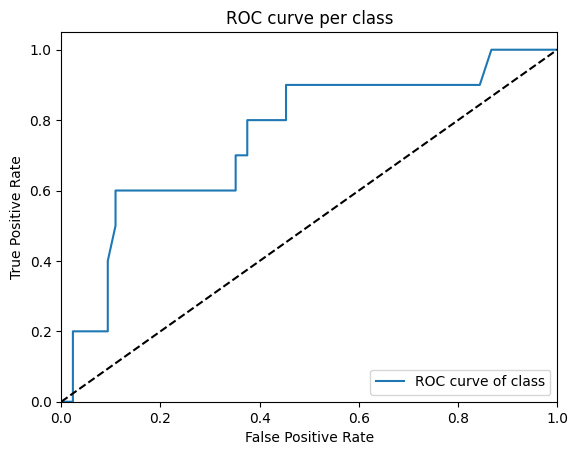

In [ ]:
plt.plot(fpr, tpr, label='ROC curve of class')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

clf_1=AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(max_depth=4),n_estimators=2*T, algorithm='SAMME.R')
clf_1.fit(X_train, Y_train)

acc_boost_train = clf_1.score(X_train, Y_train)
acc_boost_test = clf_1.score(X_test, Y_test)

o_test = clf_1.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

print("Accuracy Real AdaBoost Train",100*acc_boost_train)
print("Accuracy Real AdaBoost Test",100*acc_boost_test)

AUC: 0.79609375
Accuracy Real AdaBoost Train 100.0
Accuracy Real AdaBoost Test 91.30434782608695


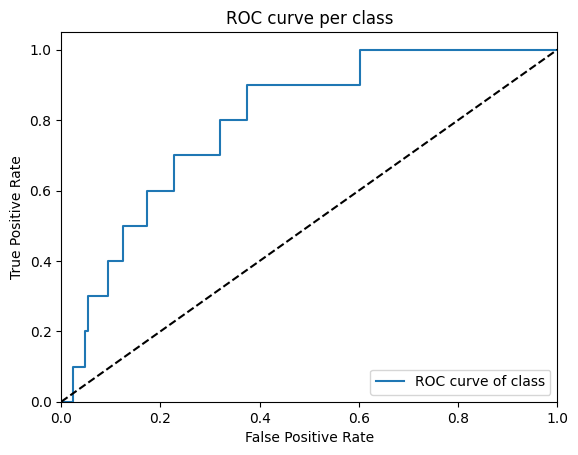

In [ ]:
plt.plot(fpr, tpr, label='ROC curve of class')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per class')
plt.legend(loc="lower right")
plt.show()

### Exercise 4.2 Correction of the dataset imbalancing

We now want to improve the performance of these sets by correcting the effect of dataset unbalancing, so that we can better learn the distribution of the positive versus negative class. For this purpose, the following approaches are commonly used:
* **Correction by subsampling**, sampling the training set so that we randomly either include repeated samples from the minority class or undersmapling the majority class and get to equalize the proportions between the two classes.
* **Correction by weighting the cost function**. In this case if there have $N_0$ and $N_1$ samples from each class, the cost function is modified so that the data from class $0$ are weighted by $1/N_0$ and those from class $1$ by $1/N_1$. In this way, the data of each class are weighted by the number of samples in them and in the final cost both classes are weighted equally even if there are different numbers of samples in them.

Use the subsampling criteria to correct the imbalance in the Bagging ensemble and the cost function weigthing for the AdaBoost algorithm. To do this, you can either modify the sklearn implementations or use the Bagging and Boosting functions included in the theory notebook. Compare the results of these modified versions  (in ROC/AUC) with the performance obtained in the previous section.

In the case of applying subsampling in the bagging ensemble, compute the total number of samples you want (according to `max_samples`parameter) and then include a half of them from each one of the classes.

the undersampling is a good method when we have a very big data model, because in this case we loose lot of data. In this case is better to apply an oversampling method.

Why do you think we do (or not) get to improve the performance of the original versions?

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


smote = SMOTE(sampling_strategy='auto')
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
print(Counter(Y_train_resampled))
model = AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(max_depth=4),n_estimators=T, algorithm='SAMME.R')
model.fit(X_train_resampled, Y_train_resampled)
o_test = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

acc_boost_train = model.score(X_train, Y_train)
acc_boost_test = model.score(X_test, Y_test)
print("Accuracy Real AdaBoost Train",100*acc_boost_train)
print("Accuracy Real AdaBoost Test",100*acc_boost_test)

Counter({0.0: 372, 1.0: 372})
AUC: 0.79453125
Accuracy Real AdaBoost Train 100.0
Accuracy Real AdaBoost Test 86.95652173913044


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

smote = SMOTE(sampling_strategy='auto')
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
print(Counter(Y_train_resampled))
clf = BaggingClassifier(estimator=tree.DecisionTreeClassifier(max_depth=max_depth), n_estimators=T, random_state=0, max_samples=0.5)

clf.fit(X_train_resampled, Y_train_resampled)
o_test = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test,o_test)
roc_auc = auc(fpr, tpr)

print ('AUC: ' + str(roc_auc))

acc_bagg_train = clf.score(X_train, Y_train)
acc_bagg_test = clf.score(X_test, Y_test)
print("Accuracy Bagging Train",100*acc_bagg_train)
print("Accuracy Bagging Test",100*acc_bagg_test)

Counter({0.0: 372, 1.0: 372})
AUC: 0.78125
Accuracy Bagging Train 66.99029126213593
Accuracy Bagging Test 59.42028985507246


the undersampling reduce the diversity, but a method that includes both (undersampling and oversampling) more diversity

# 9. Bias and variance trade-off

Consider that the real model behind our dasaset is given by:

$$Y = f(X) + \epsilon$$

so an observation $x$ is generated from the r.v.  $X$ and, then, it is transformed by a function $f(\cdot)$ and contaminated by an additive gaussian noise $\epsilon$ of zero mean and variance $\sigma_{\epsilon}^2$, to finally generate the target or label value $y$.

When a classifier or estimator is designed from a set of observations and labels, we design a function $\hat{f}(\cdot)$ trying to approximate as well as possible the original funtion $f(\cdot)$. In this case, **the expected squared prediction error** is:

$$ \mathbb{E} \left[ \left(Y−\hat{f}(X)\right)^2\right] = \mathbb{E} \left[ \left({f}(X) + \epsilon −\hat{f}(X)\right)^2\right] =  \left(\mathbb{E} \left[ {f}(X) \right]−\mathbb{E} \left[\hat{f}(X)\right]\right)^2 + \mathbb{E} \left[ \left(\hat{f}(X) − \mathbb{E}\left[ \hat{f}(X)\right]\right)^2\right] +  \sigma_{\epsilon}^2$$

Thus, this error can be decomposed into:
* A squared **bias** term ($\left(\mathbb{E} \left[ {f}(X) \right]−\mathbb{E} \left[\hat{f}(X)\right]\right)^2$): This terms represents the expected  difference between the prediction of the designed model and the value given by the real model.
* A **variance** term ($\mathbb{E} \left[ \left(\hat{f}(X) − \mathbb{E}\left[ \hat{f}(X)\right]\right)^2\right]$): This term measures the variability of a model prediction.
* The **noise** term. This is the noise term presenting in the generation data model.

Usually, we have a single dataset and we train a unique model, so talking about expected or average prediction values might sounds quite strange. However, to undertand what these expectations are representing, consider that we can generate different training data sets from the distribution of $X$ and, for each data set, we can create a new model. Due to randomness in the underlying data sets, the resulting models will have a range of predictions. So, the bias term measures how far these models' predictions are from the correct value; whereas, the variance measures these predictions (for a given sample) vary between different realizations of the model.



<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bias_Var.png" width="40%" >



These  error terms are related to complexity of the model and to the concepts of under-fitting and over-fitting that we reviewed in the previous notebooks:
* Imagine that we have a **complex model**, able to be adjusted to the training data. In this case, different runs of the training data will generate quite different models, presenting a high variability or **high-variance** among them. These models usually present a high risk of **overfitting** and a bad generalizaztion capability.
* Now consider a **simpler model**, that don't tend to overfit, but may **underfit** their training data since it is not able to capture data distribution. Different realizations of this model will present similar predictions, but all of them will be far from the real value to be predicted, presenting a **high bias**.

In an ideal scenario, we would have infinite data to learn our model and we should be able to reduce both the bias and variance terms to 0. However, in a real world, there is a tradeoff between minimizing the bias and minimizing the variance and we can control this with the model complexity. As we increase the model complexity (more parameters are added), we can get to reduce the bias, but the variance is increased.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bias_Var_ModelComplexity.png" width="40%" >






When you reduce the variance you ... and when you reduce the bias you overfit


### Bias and variance trade off for decision trees

Check the next cell code where the bias and variance term are computed for a decission tree classifier.

Note that, in this example, we are modeling a noise free problem ($\sigma_{\epsilon}^2=0$). That is, we are considering $Y = f(X)$.


The squared Bias term is:  [0.1945565 0.1863672 0.1050962 0.0694119 0.0629054 0.0535578 0.0460549
 0.0400925 0.0363327 0.0325463]
The Variance term is:  [0.0558535 0.0248528 0.0959838 0.0354781 0.0386546 0.0449822 0.0491951
 0.0521175 0.0550373 0.0562237]
The MSE is:  [0.25041 0.21122 0.20108 0.10489 0.10156 0.09854 0.09525 0.09221 0.09137
 0.08877]
We can check that MSE = Bias^2 + Variance


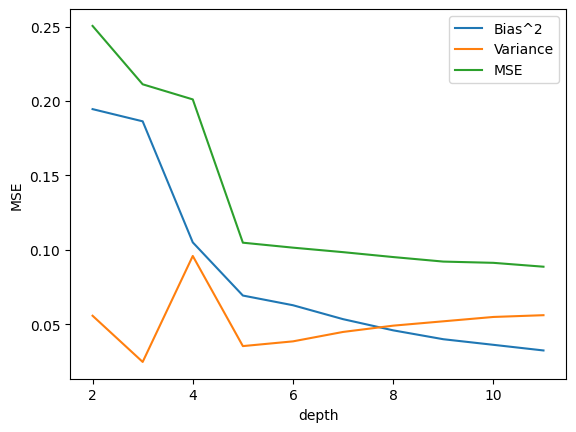

In [ ]:
niter = 100
nperc = 0.4
# Use all data together (we do not need test data anymore)
X = np.vstack((X_train_2D,X_test_2D))
Y = np.hstack((Y_train_2D,Y_test_2D))

N = X.shape[0]
Nsub = int(nperc*N)

all_f_pred = np.zeros((niter,N))

rang_depth =  np.arange(2,12)

Bias2 = np.zeros((rang_depth.shape[0],N))
Var = np.zeros((rang_depth.shape[0],N))
MSE = np.zeros((rang_depth.shape[0],N))

for d, depth in enumerate(rang_depth):

  clf_tree = tree.DecisionTreeClassifier(max_depth=depth)
  for i in range(niter):
    # Select some random samples
    samplesid = np.random.choice(N, Nsub, replace=False)
    X_train_sub  = X[samplesid,:]
    Y_train_sub  = Y[samplesid]

    # Train a tree with randomized dataset
    clf_tree.fit(X_train_sub, Y_train_sub)

    # Compute predicted output (overall available data)
    f_pred = clf_tree.predict(X)
    all_f_pred[i,:] = f_pred

  # Mean value of the predicted outputs for each data
  avg_f = np.mean(all_f_pred,axis =0)

  # Obtain the bias^2 of each data
  Bias2[d, :] = (Y - avg_f)**2
  # Obtain the var of each data
  Var[d, :] = np.mean((all_f_pred - avg_f)**2,axis=0)
  # Obtain MSE
  MSE[d,:] = np.mean((Y-all_f_pred)**2,axis=0)


# Print the results averaged over all data
Bias2mean = np.mean(Bias2,axis=1)
Varmean = np.mean(Var,axis=1)
MSEmean = np.mean(MSE,axis=1)

print("The squared Bias term is: ", Bias2mean)
print("The Variance term is: ",Varmean)
print("The MSE is: ",MSEmean)
print("We can check that MSE = Bias^2 + Variance")

plt.figure()
plt.plot(rang_depth, Bias2mean, label='Bias^2')
plt.plot(rang_depth, Varmean, label='Variance')
plt.plot(rang_depth, MSEmean, label='MSE')


plt.legend()
plt.xlabel('depth')
plt.ylabel('MSE')

plt.show()

when the number od depth is high you get a stronger model, reducing the bias but you tend you tend to overfit

### Bias and variance trade off for ensemble methods

Now, let's analyze the bias and variance terms evolution with the number of base learners in:
* a bagged ensemble.
* a RA ensemble.



In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.utils import resample

def BaggEnsemble(X_train, Y_train, X_test, Y_test, T, nperc):
  '''
  Train and evaluate a bagged ensemble of decission trees

    Args:
        X_train(numpy dnarray): training (number training data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number training data x 1).
        X_test(numpy dnarray): test data to evaluate the ensemble performance (number test data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number test data x 1).
        T: number of learners in the ensemble
        nperc: subsampling rate for the bagging process. Value from 0 (none sample is used) to 1 (all samples are used)
   Returns:
        Y_pred_train (numpy dnarray): soft-predicted outputs over the training data. It's a matrix of dimensions number of training samples,
          with the soft predicted outputs when T trees are used.
        Y_pred_test (numpy dnarray): soft-predicted outputs over the test data. It's a matrix of dimensions number of test samples,
          with the soft predicted outputs when T trees are used.

  '''

  nsamples = int(nperc*X.shape[0])  # Number of samples to select in each iteration

  Y_pred_train = np.zeros((Y_train.shape[0],))
  Y_pred_test  = np.zeros((Y_test.shape[0],))

  outputs_train = np.zeros((T,Y_train.shape[0]))
  outputs_test  = np.zeros((T,Y_test.shape[0]))


  for t in range(T):
    X_sel, Y_sel = resample(X_train,Y_train,replace=True,n_samples=nsamples)
    mytree = tree.DecisionTreeClassifier(max_depth=2)
    mytree.fit(X_sel,Y_sel)

    # Get soft outputs
    outputs_train[t,:] = np.dot(mytree.predict_proba(X_train),mytree.classes_)
    outputs_test[t,:]  = np.dot(mytree.predict_proba(X_test) ,mytree.classes_)

    Y_pred_train = np.mean(outputs_train,axis=0)
    Y_pred_test  = np.mean(outputs_test,axis=0)

  return Y_pred_train, Y_pred_test

In [ ]:
niter=100
nperc = 0.4
rangeT = np.arange(10)+1
N = Y.shape[0]
Nsub = int(nperc*N)

all_f_pred = np.zeros((niter,N))
Bias2 = np.zeros((len(rangeT),N))
Var = np.zeros((len(rangeT),N))
MSE = np.zeros((len(rangeT),N))

# Data partition and random selection is already done in the BaggEnsemble function
for a,T in enumerate(rangeT):
  for i in range(niter):
    # Select some random samples
    samplesid = np.random.choice(N, Nsub, replace=False)
    X_train_sub  = X[samplesid,:]
    Y_train_sub  = Y[samplesid]

    _, Y_predictions = BaggEnsemble(X_train_sub,Y_train_sub, X,Y, T, nperc=0.5) # It only returns the results with all learners
    all_f_pred[i,:] = Y_predictions
  # Mean value of the predicted outputs for each data
  avg_f = np.mean(all_f_pred, axis =0)
  # Obtain the bias^2 of each data
  Bias2[a, :] = (Y - avg_f)**2
  # Obtain the var of each data
  Var[a, :] = np.mean((all_f_pred - avg_f)**2,axis=0)
  # Obtain MSE
  MSE[a,:] = np.mean((Y-all_f_pred)**2,axis=0)
  print('T = %d finished' %T)

# Print the results averaged over all data
Bias2mean = np.mean(Bias2,axis=1)
Varmean = np.mean(Var,axis=1)
MSEmean = np.mean(MSE,axis=1)


T = 1 finished
T = 2 finished
T = 3 finished
T = 4 finished
T = 5 finished
T = 6 finished
T = 7 finished
T = 8 finished
T = 9 finished
T = 10 finished


The squared Bias term is:  [0.14233769 0.14168257 0.14223718 0.14251383 0.14196412 0.14198761
 0.14215782 0.14227699 0.14186986 0.14217478]
The Variance term is:  [0.01650654 0.0106663  0.00779672 0.00667756 0.0060583  0.00664826
 0.00581094 0.0051565  0.00523647 0.00468439]
The MSE is:  [0.15884424 0.15234886 0.1500339  0.14919139 0.14802242 0.14863587
 0.14796876 0.14743349 0.14710633 0.14685917]
We can check that MSE = Bias^2 + Variance


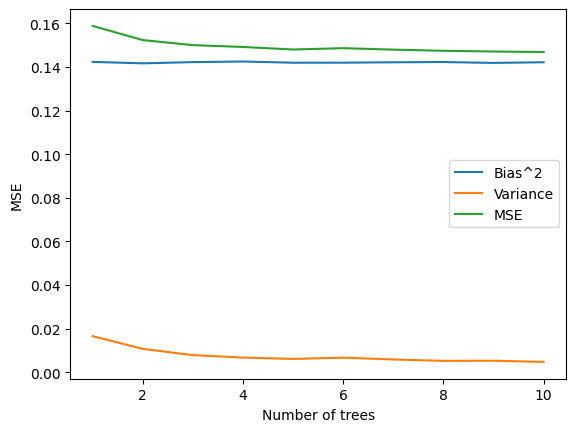

In [ ]:
print("The squared Bias term is: ", Bias2mean)
print("The Variance term is: ",Varmean)
print("The MSE is: ",MSEmean)
print("We can check that MSE = Bias^2 + Variance")

plt.figure()
plt.plot(rangeT, Bias2mean, label='Bias^2')
plt.plot(rangeT, Varmean, label='Variance')
plt.plot(rangeT, MSEmean, label='MSE')


plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.show()

**Conclusions:**

* As we use more trees in the Bagging method, the overall variance decreases.
  * Each individual tree can be quite diverse and produce somehow different outputs, depending in the data selected for training.
  * Nevertheless, when we combine enough trees in an ensemble, chances are that their average output is going to be similar.

* However, bias is not decreasing.
  * The Baggings method not really improves the classification capabilities of any of the trees.  
  * We are not increasing the complexity of the model.

In [ ]:
from sklearn.metrics import accuracy_score as acc

def RAEnsemble(X_train, Y_train, X_test, Y_test, T):
  '''
  Train and evaluate a bagged ensemble of decission trees

    Args:
        X_train(numpy dnarray): training (number training data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number training data x 1).
        X_test(numpy dnarray): test data to evaluate the ensemble performance (number test data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number test data x 1).
        T: number of learners in the ensemble
   Returns:
        Y_pred_train (numpy dnarray): predicted outputs over the training data. It's a matrix of dimensions T x number of training samples,
          where the t-th row has the predicted outputs when t trees are used.
        Y_pred_test (numpy dnarray): predicted outputs over the test data. It's a matrix of dimensions T x number of test samples,
          where the t-th row has the predicted outputs when t trees are used.
  '''
  alpha = np.zeros((T,1))
  Dt_all = np.zeros((T,X_train.shape[0]))

  outputs_train = np.zeros((T,Y_train.shape[0]))
  outputs_test  = np.zeros((T,Y_test.shape[0]))

  f_train = np.zeros((T,Y_train.shape[0]))
  f_test  = np.zeros((T,Y_test.shape[0]))

  indiv_train_acc = np.zeros((T,))

  Dt_all[0,:] = np.ones((1,X_train.shape[0])) / X_train.shape[0]  # Initialize all weights as 1 / n_samples
  for i in range(T):
    mytree = tree.DecisionTreeClassifier(max_depth=2)
    mytree.fit(X_train,Y_train,sample_weight=Dt_all[i,:])

    # For real-valued predictions:
    outputs_train[i,:] = np.dot(mytree.predict_proba(X_train),mytree.classes_)
    outputs_test[i,:]  = np.dot(mytree.predict_proba(X_test) ,mytree.classes_)

    # Get gamma and alpha_i values
    gamma = np.dot(Dt_all[i,:],np.multiply(outputs_train[i,:],Y_train))
    alpha[i] = 0.5 * np.log((1+gamma)/(1-gamma))

    # Update emphasis function (except if in the last iteration)
    if (i < T-1):
      emphasis = np.multiply(Dt_all[i,:],np.exp(-1*alpha[i]*np.multiply(outputs_train[i,:],Y_train)))
      Dt_all[i+1,:] = emphasis / np.sum(emphasis) # normalize

    # Now let's obtain the f values (outputs of each tree * alphas)
    f_train[i,:] = np.sum(np.multiply(outputs_train[0:i+1,:],alpha[0:i+1]) , axis=0) #/ np.sum(alpha[0:i+1])
    f_test[i,:]  = np.sum(np.multiply(outputs_test[0:i+1,:],alpha[0:i+1])  , axis=0) #/ np.sum(alpha[0:i+1])

  return f_train, f_test

In [ ]:
niter=100
nperc = 0.4
T = 10
N = Y.shape[0]

mean_f_pred = np.zeros((niter, T, N))
Bias2 = np.zeros((len(rangeT),N))
Var = np.zeros((len(rangeT),N))
MSE = np.zeros((len(rangeT),N))

# Data partition and random selection is already done in the BaggEnsemble function

for i in range(niter):
  # Select some random samples
  samplesid = np.random.choice(N, Nsub, replace=False)
  X_train_sub  = X[samplesid,:]
  Y_train_sub  = Y[samplesid]
  _, Y_predictions_test = RAEnsemble(X_train_sub, Y_train_sub, X, Y, T)
  mean_f_pred [i,:,:] = Y_predictions_test

for t in range(T):
  # Mean value of the predicted outputs for each data
  mean_f_pred_t = np.squeeze(mean_f_pred[:,t,:])
  # Obtain the bias^2 of each data
  Bias2[t] = (Y - np.mean(mean_f_pred_t, axis=0))**2
  # Obtain the var of each data
  Var[t] = np.mean((mean_f_pred_t - np.mean(mean_f_pred_t, axis=0))**2,axis=0)
  # Obtain MSE
  MSE[t] = np.mean((Y-mean_f_pred_t)**2,axis=0)

# Print the results averaged over all data
Bias2mean = np.mean(Bias2,axis=1)
Varmean = np.mean(Var,axis=1)
MSEmean = np.mean(MSE,axis=1)


The squared Bias term is:  [0.28786339 0.19041651 0.15102677 0.14439693 0.15761836 0.18337701
 0.21692425 0.25575041 0.29757633 0.34240981]
The Variance term is:  [0.0023598  0.0045596  0.00604595 0.00740953 0.00864384 0.00980225
 0.01096945 0.01205587 0.01323639 0.01428265]
The MSE is:  [0.29022318 0.19497611 0.15707272 0.15180646 0.1662622  0.19317926
 0.22789369 0.26780628 0.31081272 0.35669246]
We can check that MSE = Bias^2 + Variance


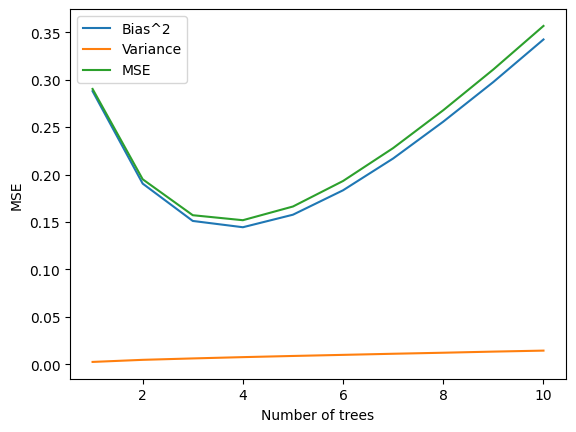

In [ ]:
print("The squared Bias term is: ", Bias2mean)
print("The Variance term is: ",Varmean)
print("The MSE is: ",MSEmean)
print("We can check that MSE = Bias^2 + Variance")

plt.figure()
plt.plot(rangeT, Bias2mean, label='Bias^2')
plt.plot(rangeT, Varmean, label='Variance')
plt.plot(rangeT, MSEmean, label='MSE')


plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.show()

**Conclusions:**

* Boosting modifies the bias:
  * The emphasis function focuses on correct the bias term of the error.
  * Here, we see as few trees get to reduce this term.
  * However, when we add more trees we overfit!!!

* However, variance is almost constant.
  * There are few variations among the outputs of the ensemble for different data realizations.

